# Voyager II

In [347]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math as m
from scipy.optimize import fsolve, brentq, newton, least_squares, fmin
from matplotlib.lines import Line2D
from matplotlib import colors
from scipy.interpolate import griddata
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import ScalarFormatter
import time
import warnings
from tqdm import tqdm
import pickle

from astropy import units as u
from astropy.time import Time
from astropy.coordinates import solar_system_ephemeris
solar_system_ephemeris.set("jpl")

from poliastro.bodies import *
from poliastro.ephem import Ephem
from poliastro.frames import Planes
from poliastro.maneuver import Maneuver
from poliastro.twobody import Orbit
from poliastro.util import norm, time_range
from poliastro.plotting.static import StaticOrbitPlotter

from itertools import permutations, combinations
from random import shuffle
import random
import statistics
import seaborn as sns
from IPython.display import HTML
import matplotlib.animation as animation

from poliastro.core.iod import vallado
from poliastro.core.elements import rv2coe
import datetime

import os
from pathlib import Path

from IPython.display import HTML, display
from matplotlib.animation import PillowWriter
import io
from base64 import b64encode

def show(variable, units):
    def get_var_name(var):
        for name, value in globals().items():
            if value is var:
                return name
    print(get_var_name(variable), "=", variable, units)

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [3]:
# Create an output directory handler
class OutputManager:
    def __init__(self, base_dir="V1"):
        #Initialise the output manager with a base directory
        self.base_dir = Path(base_dir)
        self.base_dir.mkdir(exist_ok=True)
        print(f"Output directory set to: {self.base_dir.absolute()}")
    
    def save_file(self, filename, dpi=500, bbox_inches="tight", **kwargs):
        #Save a figure with consistent settings.
        # Ensure the filename has an extension
        if not any(filename.endswith(ext) for ext in ['.png', '.jpg', '.pdf', '.svg']):
            filename = f"{filename}.png"
        
        # Create the full path
        full_path = self.base_dir / filename
        
        # Save the figure
        plt.savefig(full_path, dpi=dpi, bbox_inches=bbox_inches, **kwargs)
        print(f"Figure saved to: {full_path}")
        
        return full_path
    
    def get_path(self, filename):
        """Get the full path for a file."""
        return self.base_dir / filename
 
# Create an instance of the output manager
output_figures = OutputManager("Voyager 2 - Figures")
output_pickle = OutputManager("Raw Results")
output_ani = OutputManager("Voyager 2 - Animations")

Output directory set to: /Users/snath2/Desktop/Aero & Astro/Year 3/IP/Final IP/Optimisation Algorithms/Voyager 2 - Figures
Output directory set to: /Users/snath2/Desktop/Aero & Astro/Year 3/IP/Final IP/Optimisation Algorithms/Raw Results
Output directory set to: /Users/snath2/Desktop/Aero & Astro/Year 3/IP/Final IP/Optimisation Algorithms/Voyager 2 - Animations


In [4]:
global_flag = True

In [5]:
mu_earth = Earth.k.to(u.km**3/u.s**2).value
mu_jupiter = Jupiter.k.to(u.km**3/u.s**2).value
mu_saturn = Saturn.k.to(u.km**3/u.s**2).value
mu_uranus = Uranus.k.to(u.km**3/u.s**2).value
mu_neptune = Neptune.k.to(u.km**3/u.s**2).value
mu_sun = Sun.k.to(u.km**3/u.s**2).value
mu_sun

132712442099.00002

In [6]:
mu = mu_sun # Sun's gravitational parameter (km³/s²)
mu

132712442099.00002

In [7]:
# Define parula colormap (MATLAB-style) with an option to reverse
def parula_map(reverse=False):
    # RGB values
    cm_data = [
        [0.2081, 0.1663, 0.5292], [0.2116, 0.1898, 0.5777], [0.2123, 0.2138, 0.6270],
        [0.2081, 0.2386, 0.6771], [0.1959, 0.2645, 0.7279], [0.1707, 0.2919, 0.7792],
        [0.1253, 0.3242, 0.8303], [0.0591, 0.3598, 0.8683], [0.0117, 0.3875, 0.8820],
        [0.0060, 0.4086, 0.8828], [0.0165, 0.4266, 0.8786], [0.0329, 0.4430, 0.8720],
        [0.0498, 0.4586, 0.8641], [0.0629, 0.4737, 0.8554], [0.0723, 0.4887, 0.8467],
        [0.0779, 0.5040, 0.8384], [0.0793, 0.5200, 0.8312], [0.0749, 0.5375, 0.8263],
        [0.0641, 0.5570, 0.8240], [0.0488, 0.5772, 0.8228], [0.0343, 0.5966, 0.8199],
        [0.0265, 0.6137, 0.8135], [0.0239, 0.6287, 0.8038], [0.0231, 0.6418, 0.7913],
        [0.0228, 0.6535, 0.7768], [0.0267, 0.6642, 0.7607], [0.0384, 0.6743, 0.7436],
        [0.0590, 0.6838, 0.7254], [0.0843, 0.6928, 0.7062], [0.1133, 0.7015, 0.6859],
        [0.1453, 0.7098, 0.6646], [0.1801, 0.7177, 0.6424], [0.2178, 0.7250, 0.6193],
        [0.2586, 0.7317, 0.5954], [0.3022, 0.7376, 0.5712], [0.3482, 0.7424, 0.5473],
        [0.3953, 0.7459, 0.5244], [0.4420, 0.7481, 0.5033], [0.4871, 0.7491, 0.4840],
        [0.5300, 0.7491, 0.4661], [0.5709, 0.7485, 0.4494], [0.6099, 0.7473, 0.4337],
        [0.6473, 0.7456, 0.4188], [0.6834, 0.7435, 0.4044], [0.7184, 0.7411, 0.3905],
        [0.7525, 0.7384, 0.3768], [0.7858, 0.7356, 0.3633], [0.8185, 0.7327, 0.3498],
        [0.8507, 0.7299, 0.3360], [0.8824, 0.7274, 0.3217], [0.9139, 0.7258, 0.3063],
        [0.9450, 0.7261, 0.2886], [0.9739, 0.7314, 0.2666], [0.9938, 0.7455, 0.2403],
        [0.9990, 0.7653, 0.2164], [0.9955, 0.7861, 0.1967], [0.9880, 0.8066, 0.1794],
        [0.9789, 0.8271, 0.1633], [0.9697, 0.8481, 0.1475], [0.9626, 0.8705, 0.1309],
        [0.9589, 0.8949, 0.1132], [0.9598, 0.9218, 0.0948], [0.9661, 0.9514, 0.0755],
        [0.9763, 0.9831, 0.0538]
    ]
    
    if reverse:
        cm_data = cm_data[::-1]  # Reverse the list if specified
        
    return colors.ListedColormap(cm_data)

## 1) Choose the epochs $T_1$ to $T_N$, corresponding to all the planets $P_1$ to $P_N$ in the mission. This is decided later in the optimisation algorithm.

In [9]:
#Voyager II real mission timing
scale = "tt"

date_departure = "1977-08-23 11:29:11"

date_flyby_jupiter = "1979-07-09 22:29:51"
date_flyby_saturn = "1981-08-26 03:24:57"
date_flyby_uranus = "1986-08-24 17:59:47"

date_arrival = date_flyby_neptune = "1989-08-25 03:56:36"

### 1.1) Convert epochs to MJD

In [11]:
from astropy.time import Time
# e.g T_et = "1979-03-05 12:05:26"
def convert_ET(T_et):
    # Defines time scale for astropy.time of ET, which approx equal to TT 
    T_tt = Time(T_et, scale='tt')
    # Calculate TDB (only 1-2 milliseconds different from ET/TT)
    T_tdb = T_tt.tdb
    # Calculates the TAI (T_tai = T_tt - 32.184s)
    T_tai = T_tt.tai
    # Calculates the JD from epoch 1st January 4713 BC at 12:00 TT
    T_jd = T_tt.jd 
    # Calculates MJD
    T_mjd = T_jd - 2400000.5 
    # Calculate UTC using NASA's Sprice Time Subsystem
    T_utc = T_tt.utc
    return {"TDB": T_tdb, "TAI": T_tai, "JD": T_jd, "MJD": T_mjd, "UTC": T_utc}

scale = "mjd"

date_departure_mjd = convert_ET(date_departure)['MJD']

date_flyby_jupiter_mjd = convert_ET(date_flyby_jupiter)['MJD']

date_flyby_saturn_mjd = convert_ET(date_flyby_saturn)['MJD']

date_flyby_uranus_mjd = convert_ET(date_flyby_uranus)['MJD']

date_flyby_neptune_mjd = convert_ET(date_flyby_neptune)['MJD']

show(date_departure_mjd,"MJD")
show(date_flyby_jupiter_mjd,"MJD")
show(date_flyby_saturn_mjd,"MJD")
show(date_flyby_uranus_mjd,"MJD")
show(date_flyby_neptune_mjd,"MJD")

date_departure_mjd = 43378.478599537164 MJD
date_flyby_jupiter_mjd = 44063.93739583343 MJD
date_flyby_saturn_mjd = 44842.142326388974 MJD
date_flyby_uranus_mjd = 46666.74984953692 MJD
date_flyby_neptune_mjd = 47763.164305555634 MJD


### 1.2) Find the $\Delta t$ for each mission trajectory

In [13]:
def find_tof(start_date_days, end_date_days):
    delta_t = (end_date_days - start_date_days) * (60*60*24)
    return delta_t

delta_t_earth_jupiter = find_tof(date_departure_mjd, date_flyby_jupiter_mjd)
delta_t_jupiter_saturn = find_tof(date_flyby_jupiter_mjd, date_flyby_saturn_mjd)
delta_t_saturn_uranus = find_tof(date_flyby_saturn_mjd, date_flyby_uranus_mjd)
delta_t_uranus_neptune = find_tof(date_flyby_uranus_mjd, date_flyby_neptune_mjd)

print("Earth-Jupiter:",delta_t_earth_jupiter,"s")
print("Jupiter-Saturn:",delta_t_jupiter_saturn,"s")
print("Saturn-Uranus:",delta_t_saturn_uranus,"s")
print("Uranus-Neptune:",delta_t_uranus_neptune,"s")

Earth-Jupiter: 59223639.999997616 s
Jupiter-Saturn: 67236905.99999875 s
Saturn-Uranus: 157646089.9999827 s
Uranus-Neptune: 94730209.00001675 s


## 2) Using the known epochs $T_1$ to $T_N$, calculate their respective planetary state vectors $\{\vec{\mathbf{r}},\vec{\mathbf{V}}^{\,(\text{P})}\}$ using Algorithm 3.3.

In [15]:
def get_planet_state_vector(planet, date_time, scale):
    # Convert the date_time in MJD to modern TDB time scale 
    date = Time(date_time, format='mjd', scale=scale).tdb
    # Generate the planet's ephemeris at the given time
    planet_ephem = Ephem.from_body(planet, date, plane=Planes.EARTH_ECLIPTIC)
    # Extract the position and velocity vectors
    r, v = planet_ephem.rv(date)
    r = r.to(u.km)
    v = v.to(u.km/u.s) 
    return r, v

scale = 'tt'
r_earth, v_earth = get_planet_state_vector(Earth, date_departure_mjd, scale)
r_jupiter, v_jupiter = get_planet_state_vector(Jupiter, date_flyby_jupiter_mjd, scale)
r_saturn, v_saturn = get_planet_state_vector(Saturn, date_flyby_saturn_mjd, scale)
r_uranus, v_uranus = get_planet_state_vector(Uranus, date_flyby_uranus_mjd, scale)
r_neptune, v_neptune = get_planet_state_vector(Neptune, date_flyby_neptune_mjd, scale)

In [16]:
print("Earth:")
display(r_earth, v_earth)
print("Jupiter:")
display(r_jupiter, v_jupiter)
print("Saturn:")
display(r_saturn, v_saturn)
print("Uranus:")
display(r_uranus, v_uranus)
print("Neptune:")
display(r_neptune, v_neptune)

Earth:


<Quantity [ 1.32030625e+08, -7.50565438e+07, -1.25679411e+04] km>

<Quantity [1.41701081e+01, 2.58268287e+01, 4.44188339e-04] km / s>

Jupiter:


<Quantity [-5.87840885e+08,  5.37248924e+08,  1.09519858e+07] km>

<Quantity [-8.96234142, -9.04257987,  0.23792779] km / s>

Saturn:


<Quantity [-1.40383659e+09, -2.91499481e+08,  6.08830203e+07] km>

<Quantity [ 1.44947246, -9.47429577,  0.10784132] km / s>

Uranus:


<Quantity [-4.27172438e+08, -2.83352195e+09, -4.98358540e+06] km>

<Quantity [ 6.68279762, -1.33268008, -0.09162107] km / s>

Neptune:


<Quantity [ 8.97426414e+08, -4.42924657e+09,  7.05247447e+07] km>

<Quantity [ 5.29199419,  1.10935555, -0.14477766] km / s>

In [17]:
r_earth, v_earth = r_earth.value, v_earth.value
r_jupiter, v_jupiter = r_jupiter.value, v_jupiter.value
r_saturn, v_saturn = r_saturn.value, v_saturn.value
r_uranus, v_uranus = r_uranus.value, v_uranus.value
r_neptune, v_neptune = r_neptune.value, v_neptune.value

## 3) Now, to define the transfer trajectory we separate them into legs: $P_1\text{-}P_2$, $P_2\text{-}P_3$, ..., $P_{N-1}\text{-}P_N$. For each leg, we can use the solution to Lambert's Problem (Algorithm 3.4) to get its transfer velocity vectors. This fully defines each leg, where for instance $P_1\text{-}P_2$ leg, we have the following parameters $\big\{\vec{\mathbf{r}}_{1}, \vec{\mathbf{r}}_{2}, \vec{\mathbf{V}}^{\,(\text{P})}_1,\vec{\mathbf{V}}^{\,(\text{P})}_2, (\vec{\mathbf{v}})_{D}, (\vec{\mathbf{v}}_{T_2})_{A}, \Delta t\big\}$.

https://docs.poliastro.space/en/stable/autoapi/poliastro/core/iod/index.html

In [19]:
# from poliastro.core.iod import vallado

# # Lambert Solver
# def lambert(r1, r2, delta_t):
#     v_d, v_a = vallado(mu_sun, r1, r2, delta_t, M=0, prograde=True, lowpath=True, numiter=1e6, rtol=1e-8)
#     return v_d, v_a

import numpy as np
from scipy.optimize import brentq, newton, least_squares

# Known parameters [r1, r2, delta_t]
mu = 1.327e11  # Sun's gravitational parameter (km^3/s^2)


# Stumpff functions
def C(z):
    if z > 0:
        return (1 - np.cos(np.sqrt(z))) / z
    elif z < 0:
        return (np.cosh(np.sqrt(-z)) - 1) / (-z)
    else:
        return 0.5


def S(z):
    if z > 0:
        return (np.sqrt(z) - np.sin(np.sqrt(z))) / (z**1.5)
    elif z < 0:
        return (np.sinh(np.sqrt(-z)) - np.sqrt(-z)) / ((-z) ** 1.5)
    else:
        return 1 / 6


# Compute y parameter
def compute_y(z, r1, r2, A):
    C_z = max(C(z), 1e-8)  # Ensure no division by zero
    return max(r1 + r2 + A * (z * S(z) - 1) / np.sqrt(C_z), 1e-8)


# Time-of-flight equation
def F_lambert(z, delta_t, r1, r2, A):
    y_val = compute_y(z, r1, r2, A)
    return ((y_val / C(z)) ** 1.5) * S(z) + A * np.sqrt(y_val) - np.sqrt(mu) * delta_t


# Lambert solver
def lambert(r1, r2, deltat):
    # Step 1: Find the delta_theta between P1 and P2
    r1_mag, r2_mag = np.linalg.norm(r1), np.linalg.norm(r2)
    delta_theta = np.arccos(np.dot(r1, r2) / (r1_mag * r2_mag))

    if np.cross(r1, r2)[2] < 0:
        delta_theta = 2 * np.pi - delta_theta

    # Step 2: Solve for the intermediate auxiliary variable z
    A = np.sin(delta_theta) * np.sqrt(r1_mag * r2_mag / (1 - np.cos(delta_theta)))

    def func(z_val):
        return F_lambert(z_val, deltat, r1_mag, r2_mag, A)

    def solver(func, z_min=-1e3, z_max=1e3, z_guess=0.01):
        try:
            z = brentq(lambda z: func(z), z_min, z_max)
        except ValueError:
            try:
                z = newton(func, z_guess)
            except RuntimeError:
                z = least_squares(func, z_guess).x[0]
        return z

    z = solver(func)
    y_val = compute_y(z, r1_mag, r2_mag, A)

    # Step 3: Compute Lagrange coefficients f, g, gdot
    f = 1 - y_val / r1_mag
    g = A * np.sqrt(y_val / mu)
    gdot = 1 - y_val / r2_mag

    v1 = (r2 - f * r1) / g
    v2 = (gdot * r2 - r1) / g
    return v1, v2


v1_d, v2_a = lambert(r_earth, r_jupiter, delta_t_earth_jupiter)
v2_d, v3_a = lambert(r_jupiter, r_saturn, delta_t_jupiter_saturn)
v3_d, v4_a = lambert(r_saturn, r_uranus, delta_t_saturn_uranus)
v4_d, v5_a = lambert(r_uranus, r_neptune, delta_t_uranus_neptune)
print(v1_d, v2_a)
print(v2_d, v3_a)
print(v3_d, v4_a)
print(v4_d, v5_a)

[16.74455318 34.95333345  2.38458348] [-9.58617521 -1.22743495 -0.35734302]
[-16.60866876 -10.4653879    0.87506523] [ -8.892451   -12.58488149   0.6225087 ]
[  3.38230315 -18.31306338  -0.30955557] [  7.28171252 -14.19004446  -0.45029021]
[ 13.96910355 -17.41059278   0.79967209] [ 13.94444629 -16.42954098   0.79276345]


In [20]:
print(np.linalg.norm(v1_d), np.linalg.norm(v2_a))
print(np.linalg.norm(v2_d), np.linalg.norm(v3_a))
print(np.linalg.norm(v3_d), np.linalg.norm(v4_a))
print(np.linalg.norm(v4_d), np.linalg.norm(v5_a))

38.83042387903412 9.671041604457056
19.65039341010871 15.422141356055736
18.62536146178326 15.955671725777824
22.336160600690874 21.563994831378054


## 4) We can now work out $\Delta V_{injection}$, the initial injection burn from $P_1$ into transfer orbit,

In [22]:
deltaV_injection = v1_d - v_earth
deltaV_injection = np.linalg.norm(deltaV_injection)
deltaV_injection

9.777779726682427

## Flyby Jupiter

### 5) Find $\Delta V_{p\,{(flyby)}}$, we must first find the hyperbolic excess velocities $\{\vec{\mathbf{v}}_{\infty_{in}},\vec{\mathbf{v}}_{\infty_{out}} \}$ at each flyby planet

### 6) Find the planet's inbound $a_{in}$ and outbound $a_{out}$ semi-major axis

### 7) Find its deflection (turning) angle $\delta$ from entering SOI to exiting SOI

#### Here, we can utilise the equation relating deflection (turning) angle $\delta$ to the outbound eccentricity $e_{out}$ of hyperbolic trajectory,

### 8) Hence, the radius of the closest approach to the planet $r_{p\,{(flyby)}}$ can be calculated

### 9) We now have all the required parameter to equate $\Delta V_{p\,{(flyby)}}$,

In [30]:
R_jupiter = 69911 #km
R_saturn = 58232 #km
R_uranus = 25362 #km
R_neptune = 24622 #km

R_jupiter_SOI = 48.2e6 #km
R_saturn_SOI = 54.5e6 #km
R_uranus_SOI = 51.9e6 #km
R_neptune_SOI = 86.2e6 #km

In [31]:
# Add must be more than R_planet but less that r_SOI <-- NEED TO ADD!!!!!

def find_deltaV_flyby(v_in, v_out, v_planet, mu_planet, R_planet, R_SOI):
    vinf_in = v_in - v_planet
    vinf_out = v_out - v_planet

    a_in = - mu_planet/np.linalg.norm(vinf_in)**2
    a_out = - mu_planet/np.linalg.norm(vinf_out)**2

    deflection = np.arccos( np.dot(vinf_in,vinf_out)/( np.linalg.norm(vinf_in) * np.linalg.norm(vinf_out) ) )

    e_out = 1/np.sin(deflection/2)
    # def f(e_out):
    #     return (a_out/a_in * (e_out - 1))*np.sin( deflection - np.arcsin(1/e_out) ) - 1   
    # e_out = fsolve(f, 1.1)[0]

    rp = a_out*(1-e_out)

    if rp < R_planet and rp > R_SOI:  
        deltaV_flyby = 1e99
    else:
        vp_esc = np.sqrt(2*mu_planet/rp)
        
        vp_flyby_in = np.sqrt( np.linalg.norm(vinf_in)**2 + (2 * mu_planet)/rp )

        if vp_flyby_in > vp_esc:
            deltaV_flyby = abs(np.sqrt( np.linalg.norm(vinf_out)**2 + (2 * mu_planet)/rp ) - np.sqrt( np.linalg.norm(vinf_in)**2 + (2 * mu_planet)/rp ) )
        else:
            deltaV_flyby = 1e99

    return deltaV_flyby, rp

deltaV_jupiter, rp_jupiter = find_deltaV_flyby(v2_a, v2_d, v_jupiter, mu_jupiter, R_jupiter, R_jupiter_SOI)
deltaV_saturn, rp_saturn = find_deltaV_flyby(v3_a, v3_d, v_saturn, mu_saturn, R_saturn, R_saturn_SOI)
deltaV_uranus, rp_uranus = find_deltaV_flyby(v4_a, v4_d, v_uranus, mu_uranus, R_uranus, R_uranus_SOI)

print("Jupiter Flyby:",deltaV_jupiter)
print("Saturn Flyby:",deltaV_saturn)
print("Neptune Flyby:",deltaV_uranus)

Jupiter Flyby: 0.022610023336749663
Saturn Flyby: 0.8231855964923582
Neptune Flyby: 3.738902467573496


## 10) Finally, to summate all the individual $\Delta V$ components of the initial injection and subsequent flybys we can equate,

In [33]:
deltaV_total = deltaV_injection + deltaV_jupiter + deltaV_saturn + deltaV_uranus
deltaV_total

14.36247781408503

In [34]:
(date_departure_mjd, date_flyby_jupiter_mjd, date_flyby_saturn_mjd, date_flyby_uranus_mjd, date_flyby_neptune_mjd)

(43378.478599537164,
 44063.93739583343,
 44842.142326388974,
 46666.74984953692,
 47763.164305555634)

---

## 11) From the calculated mission $\Delta V$, we can find the fuel mass $M_f$ used.

In [37]:
M0_Voyager = 2066 #kg 

M0_propulsion_module = 1207 #kg
Mf_propulsion_module = 1039 #kg

M0_mission_module = 825 #kg
Mf_mission_module = 100 #kg

Mf_total_NASA = Mf_propulsion_module + Mf_mission_module

In [38]:
F = 68054 #N
t = 43 #s
g0 = 9.80665 # m/s2

# The Isp of the actual Voyager I mission - propulsion module
Isp_NASA = (F*t)/(Mf_propulsion_module*g0)
Isp_NASA, 's'

(287.2009612891239, 's')

**Specific impulse ($I_{sp}$)** is a measure of a rocket engine's efficiency, defined as the impulse (thrust per unit weight flow of propellant) delivered per unit of propellant consumed.

### My Real Simulation Data

In [41]:
def find_Isp(Mf, M0, deltaV):
    Isp = (deltaV*1e3)/( np.log(M0/(M0 - Mf)) * g0)
    return Isp

Isp_my_sim = find_Isp(Mf_total_NASA, M0_Voyager, deltaV_total)
Isp_my_sim, 's'

(1827.471618785223, 's')

The difference in $I_{sp}$ of NASA data and my_sim data is due to the inherit assumption in my model (Method of Patched Conics and Lambert Transfers) -- also the unpowered gravitational assist assumption.

Also, due to the fact NASA used a 2 stage system with the propulsion system ejected after injection into Earth-Jupiter transfer orbit. This left a 825kg mission module with around 100kg of fuel on it.

In [43]:
Vex = Isp_my_sim*g0 / 1000 # km/s
Vex, 'km/s'

(17.921374550360106, 'km/s')

In [44]:
M0_Voyager = M0 = 2066 #kg 

In [45]:
def compute_fuel_mass(M0, Vex, deltaV):
    Mf = M0*( 1 - np.exp(-deltaV/Vex) )
    return Mf 
    
fuel_mass_total = compute_fuel_mass(M0, Vex, deltaV_total)

print(f"The mission deltaV of {deltaV_total:.4f} km/s caused {fuel_mass_total:.2f} kg of fuel used.")

The mission deltaV of 14.3625 km/s caused 1139.00 kg of fuel used.


---

# Function: find_deltaV_mission()

In [48]:
def find_deltaV_mission(date_departure_mjd, date_flyby_jupiter_mjd, date_flyby_saturn_mjd, 
                        date_flyby_uranus_mjd, date_flyby_neptune_mjd):
    #Step 1 - Find delta t
    delta_t_earth_jupiter = find_tof(date_departure_mjd, date_flyby_jupiter_mjd)
    delta_t_jupiter_saturn = find_tof(date_flyby_jupiter_mjd, date_flyby_saturn_mjd)
    delta_t_saturn_uranus = find_tof(date_flyby_saturn_mjd, date_flyby_uranus_mjd)
    delta_t_uranus_neptune = find_tof(date_flyby_uranus_mjd, date_flyby_neptune_mjd)
    tof = delta_t_earth_jupiter + delta_t_jupiter_saturn + delta_t_saturn_uranus + delta_t_uranus_neptune #s

    #Step 2 - Find planetary state vectors
    scale = 'tt'
    r_earth, v_earth = get_planet_state_vector(Earth, date_departure_mjd, scale)
    r_jupiter, v_jupiter = get_planet_state_vector(Jupiter, date_flyby_jupiter_mjd, scale)
    r_saturn, v_saturn = get_planet_state_vector(Saturn, date_flyby_saturn_mjd, scale)
    r_uranus, v_uranus = get_planet_state_vector(Uranus, date_flyby_uranus_mjd, scale)
    r_neptune, v_neptune = get_planet_state_vector(Neptune, date_flyby_neptune_mjd, scale)

    r_earth, v_earth = r_earth.value, v_earth.value
    r_jupiter, v_jupiter = r_jupiter.value, v_jupiter.value
    r_saturn, v_saturn = r_saturn.value, v_saturn.value
    r_uranus, v_uranus = r_uranus.value, v_uranus.value
    r_neptune, v_neptune = r_neptune.value, v_neptune.value

    #Step 3 - Define trajectory fully using Lambert Transfer
    v1_d, v2_a = lambert(r_earth, r_jupiter, delta_t_earth_jupiter)
    v2_d, v3_a = lambert(r_jupiter, r_saturn, delta_t_jupiter_saturn)
    v3_d, v4_a = lambert(r_saturn, r_uranus, delta_t_saturn_uranus)
    v4_d, v5_a = lambert(r_uranus, r_neptune, delta_t_uranus_neptune)
        
    #Step 4 - Injection deltaV
    deltaV_injection = v1_d - v_earth
    deltaV_injection = np.linalg.norm(deltaV_injection)
    
    #Step 5 - Find deltaV of flyby#
    deltaV_jupiter, rp_jupiter = find_deltaV_flyby(v2_a, v2_d, v_jupiter, mu_jupiter, R_jupiter, R_jupiter_SOI)
    deltaV_saturn, rp_saturn = find_deltaV_flyby(v3_a, v3_d, v_saturn, mu_saturn, R_saturn, R_saturn_SOI)
    deltaV_uranus, rp_uranus = find_deltaV_flyby(v4_a, v4_d, v_uranus, mu_uranus, R_uranus, R_uranus_SOI)
    
    #Step 6 - Find total deltaV of mission
    deltaV_total = deltaV_injection + deltaV_jupiter + deltaV_saturn + deltaV_uranus
    if delta_t_earth_jupiter <= 0 or delta_t_jupiter_saturn <= 0 or delta_t_saturn_uranus <= 0 or delta_t_uranus_neptune <= 0:
        deltaV_total = np.inf

    #Step 7 - Find the fuel mass used
    fuel_mass_total = compute_fuel_mass(M0, Vex, deltaV_total)

    data_dict = {
        "deltaV_injection (km/s)": deltaV_injection,
        "deltaV_jupiter (km/s)": deltaV_jupiter,
        "deltaV_saturn (km/s)": deltaV_saturn,
        "deltaV_uranus (km/s)": deltaV_uranus,
        "rp_jupiter (km)": rp_jupiter,
        "rp_saturn (km)": rp_saturn,
        "rp_uranus (km)": rp_uranus,
        "tof (days)": tof/(60*60*24)
    }
       
    return deltaV_total, fuel_mass_total, data_dict

deltaV_REAL, fuel_mass_REAL, data_dict_REAL = find_deltaV_mission(date_departure_mjd, date_flyby_jupiter_mjd, date_flyby_saturn_mjd, 
                        date_flyby_uranus_mjd, date_flyby_neptune_mjd)
deltaV_REAL, fuel_mass_REAL, data_dict_REAL

(14.36247781408503,
 1139.0,
 {'deltaV_injection (km/s)': 9.777779726682427,
  'deltaV_jupiter (km/s)': 0.022610023336749663,
  'deltaV_saturn (km/s)': 0.8231855964923582,
  'deltaV_uranus (km/s)': 3.738902467573496,
  'rp_jupiter (km)': 712698.8242066916,
  'rp_saturn (km)': 217314.15315946675,
  'rp_uranus (km)': 77945.15343930262,
  'tof (days)': 4384.68570601847})

In [49]:
dates_REAL = [date_departure_mjd, date_flyby_jupiter_mjd, date_flyby_saturn_mjd, date_flyby_uranus_mjd, date_flyby_neptune_mjd]
dates_REAL

[43378.478599537164,
 44063.93739583343,
 44842.142326388974,
 46666.74984953692,
 47763.164305555634]

---

# Optimisation Algorithms

In [52]:
def MJD_to_TT_calander_date(T_mjd):
    T_TT = Time(T_mjd, format='mjd', scale='tt') #Time object: scale='tt' format='mjd'
    return T_TT.iso

MJD_to_TT_calander_date(date_departure_mjd)

'1977-08-23 11:29:11.000'

In [53]:
convert_ET( MJD_to_TT_calander_date(date_departure_mjd) )['UTC']

<Time object: scale='utc' format='iso' value=1977-08-23 11:28:22.816>

In [54]:
change_in_time_days = 365

## Brute force Algorithm

### 1.1) Find the $\Delta t$ for each mission trajectory

In [57]:
print("Earth-Jupiter:",delta_t_earth_jupiter/(60*60*24),"days")
print("Jupiter-Saturn:",delta_t_jupiter_saturn/(60*60*24),"days")
print("Saturn-Uranus:",delta_t_saturn_uranus/(60*60*24),"days")
print("Uranus-Neptune:",delta_t_uranus_neptune/(60*60*24),"days")

Earth-Jupiter: 685.4587962962687 days
Jupiter-Saturn: 778.2049305555411 days
Saturn-Uranus: 1824.607523147948 days
Uranus-Neptune: 1096.4144560187124 days


### 1.2) Define the range for each date allowed for algorithm

In [370]:
population = spacing = 15
print("No. of Iterations:",spacing**5)

No. of Iterations: 759375


In [60]:
time_range_LIST = np.linspace(-change_in_time_days, change_in_time_days, spacing)
time_range_LIST

array([-365.        , -283.88888889, -202.77777778, -121.66666667,
        -40.55555556,   40.55555556,  121.66666667,  202.77777778,
        283.88888889,  365.        ])

In [61]:
departure_time_range_LIST = np.linspace(-change_in_time_days, change_in_time_days, spacing)
departure_time_range_LIST

array([-365.        , -283.88888889, -202.77777778, -121.66666667,
        -40.55555556,   40.55555556,  121.66666667,  202.77777778,
        283.88888889,  365.        ])

In [62]:
flyby_jupiter_time_range_LIST = np.linspace(-change_in_time_days, change_in_time_days, spacing)
flyby_jupiter_time_range_LIST

array([-365.        , -283.88888889, -202.77777778, -121.66666667,
        -40.55555556,   40.55555556,  121.66666667,  202.77777778,
        283.88888889,  365.        ])

In [63]:
flyby_saturn_time_range_LIST = np.linspace(-change_in_time_days, change_in_time_days, spacing)
flyby_saturn_time_range_LIST

array([-365.        , -283.88888889, -202.77777778, -121.66666667,
        -40.55555556,   40.55555556,  121.66666667,  202.77777778,
        283.88888889,  365.        ])

In [64]:
flyby_uranus_time_range_LIST = np.linspace(-change_in_time_days, change_in_time_days, spacing)
flyby_uranus_time_range_LIST

array([-365.        , -283.88888889, -202.77777778, -121.66666667,
        -40.55555556,   40.55555556,  121.66666667,  202.77777778,
        283.88888889,  365.        ])

In [65]:
flyby_neptune_time_range_LIST = np.linspace(-change_in_time_days, change_in_time_days, spacing)
flyby_neptune_time_range_LIST

array([-365.        , -283.88888889, -202.77777778, -121.66666667,
        -40.55555556,   40.55555556,  121.66666667,  202.77777778,
        283.88888889,  365.        ])

In [66]:
deltaV_REAL#, fuel_mass_REAL

14.36247781408503

### 1.3) Run Algorithm

In [68]:
%%time
#warnings.filterwarnings('ignore')

if global_flag:
    deltaV_list_BRUTE = []
    time_range_list_index = []
    dates_list = []
    
    # Start timing
    start_time = time.time()
    
    # Nested loops for all 5 mission epochs
    for i in tqdm(range(0, spacing)):  
        date_departure_mjd_BRUTE = date_departure_mjd + time_range_LIST[i]
        
        for j in range(0, spacing):  
            date_flyby_jupiter_mjd_BRUTE = date_flyby_jupiter_mjd + time_range_LIST[j]
            
            for k in range(0, spacing):  
                date_flyby_saturn_mjd_BRUTE = date_flyby_saturn_mjd + time_range_LIST[k]
                
                for l in range(0, spacing):  
                    date_flyby_uranus_mjd_BRUTE = date_flyby_uranus_mjd + time_range_LIST[l]
                    
                    for m in range(0, spacing):  
                        date_flyby_neptune_mjd_BRUTE = date_flyby_neptune_mjd + time_range_LIST[m]
                        
                        # Store index positions
                        time_range_list_index.append([i, j, k, l, m])
    
                        try:
                            # Calculate delta-V for the trajectory
                            deltaV_mission = find_deltaV_mission(
                                date_departure_mjd_BRUTE, 
                                date_flyby_jupiter_mjd_BRUTE, 
                                date_flyby_saturn_mjd_BRUTE, 
                                date_flyby_uranus_mjd_BRUTE, 
                                date_flyby_neptune_mjd_BRUTE
                            )
    
                            # Append results
                            deltaV_list_BRUTE.append(deltaV_mission)
                            dates_list.append([
                                date_departure_mjd_BRUTE, 
                                date_flyby_jupiter_mjd_BRUTE, 
                                date_flyby_saturn_mjd_BRUTE, 
                                date_flyby_uranus_mjd_BRUTE, 
                                date_flyby_neptune_mjd_BRUTE,
                                deltaV_mission
                            ])
    
                        except Exception:
                            deltaV_list_BRUTE.append([1e99, 1e99, {'temp': 1e99}])  # Handle failures gracefully
    
    # End timing
    end_time = time.time()
    execution_time_BRUTE_FORCE = end_time - start_time
    
    # Print execution time
    print(f"\nExecution Time: {execution_time_BRUTE_FORCE:.4f} seconds")

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 4.05 µs


For spacing =
For spacing = 15 --> Execution Time = 1h 15min

In [70]:
#deltaV_list_BRUTE

# Contour plot of the problem space --> look at local minima
# Holo View
#deltaV_list_BRUTE
#dates_list

In [71]:
if global_flag:
    filename_brute = output_pickle.get_path("brute_results_V2.pkl")
    
    results_brute = {
        "deltaV_list_BRUTE": deltaV_list_BRUTE,
        "time_range_list_index": time_range_list_index,
        "dates_list": dates_list,
        "execution_time_BRUTE_FORCE": execution_time_BRUTE_FORCE
        
    }
    with open(filename_brute, "wb") as f:
        pickle.dump(results_brute, f)

In [72]:
filename_brute = output_pickle.get_path("brute_results_V2.pkl")

with open(filename_brute, "rb") as f:
    data = pickle.load(f)

deltaV_list_BRUTE = data["deltaV_list_BRUTE"]
time_range_list_index = data["time_range_list_index"]
dates_list = data["dates_list"]
execution_time_BRUTE_FORCE = data["execution_time_BRUTE_FORCE"]

if not global_flag:
    print(f"Execution Time: {execution_time_BRUTE_FORCE:.4f} seconds")

Execution Time: 630.3744 seconds


In [73]:
deltaV_BRUTE_MIN, fuel_mass_BRUTE_MIN, data_dict_BRUTE_MIN = min(deltaV_list_BRUTE, key=lambda x: x[1]) #min(deltaV_list_BRUTE)
deltaV_BRUTE_MIN, fuel_mass_BRUTE_MIN, data_dict_BRUTE_MIN

(10.192898693827132,
 896.1706929705995,
 {'deltaV_injection (km/s)': 9.477237719217307,
  'deltaV_jupiter (km/s)': 0.5826092617392575,
  'deltaV_saturn (km/s)': 0.09611727527946101,
  'deltaV_uranus (km/s)': 0.03693443759110693,
  'rp_jupiter (km)': 96694.86737610104,
  'rp_saturn (km)': 166934.94660901834,
  'rp_uranus (km)': 139025.60162481232,
  'tof (days)': 5033.574594907361})

In [74]:
data_dict_BRUTE_MIN['tof (days)']

5033.574594907361

In [75]:
# Find the index of the minimum value
min_index = deltaV_list_BRUTE.index(min(deltaV_list_BRUTE, key=lambda x: x[0]))
min_index

9858

In [76]:
deltaV_BRUTE_MIN, fuel_mass_BRUTE_MIN, data_dict_BRUTE_MIN = deltaV_list_BRUTE[min_index]
deltaV_BRUTE_MIN, fuel_mass_BRUTE_MIN, data_dict_BRUTE_MIN

(10.192898693827132,
 896.1706929705995,
 {'deltaV_injection (km/s)': 9.477237719217307,
  'deltaV_jupiter (km/s)': 0.5826092617392575,
  'deltaV_saturn (km/s)': 0.09611727527946101,
  'deltaV_uranus (km/s)': 0.03693443759110693,
  'rp_jupiter (km)': 96694.86737610104,
  'rp_saturn (km)': 166934.94660901834,
  'rp_uranus (km)': 139025.60162481232,
  'tof (days)': 5033.574594907361})

In [77]:
change_in_time = time_range_list_index[min_index]
change_in_time

[0, 9, 8, 5, 8]

In [78]:
date_departure_mjd_BRUTE_MIN = date_departure_mjd + time_range_LIST[change_in_time[0]]
date_flyby_jupiter_mjd_BRUTE_MIN = date_flyby_jupiter_mjd + time_range_LIST[change_in_time[1]]
date_flyby_saturn_mjd_BRUTE_MIN = date_flyby_saturn_mjd + time_range_LIST[change_in_time[2]]
date_flyby_uranus_mjd_BRUTE_MIN = date_flyby_uranus_mjd + time_range_LIST[change_in_time[2]]
date_flyby_neptune_mjd_BRUTE_MIN = date_flyby_neptune_mjd + time_range_LIST[change_in_time[2]]

dates_list_BRUTE_MIN = [date_departure_mjd_BRUTE_MIN, date_flyby_jupiter_mjd_BRUTE_MIN, 
                        date_flyby_saturn_mjd_BRUTE_MIN, date_flyby_uranus_mjd_BRUTE_MIN, 
                        date_flyby_neptune_mjd_BRUTE_MIN]
dates_list_BRUTE_MIN

[43013.478599537164,
 44428.93739583343,
 45126.031215277864,
 46950.63873842581,
 48047.053194444525]

In [79]:
change_in_dates_list_BRUTE_MIN = [
    (date_departure_mjd - date_departure_mjd_BRUTE_MIN),
    (date_flyby_jupiter_mjd - date_flyby_jupiter_mjd_BRUTE_MIN),
    (date_flyby_saturn_mjd - date_flyby_saturn_mjd_BRUTE_MIN),
    (date_flyby_uranus_mjd - date_flyby_uranus_mjd_BRUTE_MIN),
    (date_flyby_neptune_mjd - date_flyby_neptune_mjd_BRUTE_MIN)
]
change_in_dates_list_BRUTE_MIN

[365.0, -365.0, -283.8888888888905, -283.8888888888905, -283.8888888888905]

In [80]:
print("Earth-Jupiter:",date_flyby_jupiter_mjd_BRUTE_MIN - date_departure_mjd_BRUTE_MIN,"days")
print("Jupiter-Saturn:",date_flyby_saturn_mjd_BRUTE_MIN - date_flyby_jupiter_mjd_BRUTE_MIN,"days")
print("Saturn-Uranus:",date_flyby_uranus_mjd_BRUTE_MIN - date_flyby_saturn_mjd_BRUTE_MIN,"days")
print("Uranus-Neptune:",date_flyby_neptune_mjd_BRUTE_MIN - date_flyby_uranus_mjd_BRUTE_MIN,"days")

Earth-Jupiter: 1415.4587962962687 days
Jupiter-Saturn: 697.0938194444316 days
Saturn-Uranus: 1824.607523147948 days
Uranus-Neptune: 1096.4144560187124 days


In [81]:
date_departure_BRUTE_MIN = MJD_to_TT_calander_date(date_departure_mjd_BRUTE_MIN)
date_flyby_jupiter_BRUTE_MIN = MJD_to_TT_calander_date(date_flyby_jupiter_mjd_BRUTE_MIN)
date_flyby_saturn_BRUTE_MIN = MJD_to_TT_calander_date(date_flyby_saturn_mjd_BRUTE_MIN)
date_flyby_uranus_BRUTE_MIN = MJD_to_TT_calander_date(date_flyby_uranus_mjd_BRUTE_MIN)  # Fixed
date_flyby_neptune_BRUTE_MIN = MJD_to_TT_calander_date(date_flyby_neptune_mjd_BRUTE_MIN)  # Fixed

print("Date of Departure (Min):", date_departure_BRUTE_MIN)
print("Date of Jupiter Flyby (Min):", date_flyby_jupiter_BRUTE_MIN)
print("Date of Saturn Flyby (Min):", date_flyby_saturn_BRUTE_MIN)
print("Date of Uranus Flyby (Min):", date_flyby_uranus_BRUTE_MIN)  # Fixed
print("Date of Neptune Flyby (Min):", date_flyby_neptune_BRUTE_MIN)  # Fixed

Date of Departure (Min): 1976-08-23 11:29:11.000
Date of Jupiter Flyby (Min): 1980-07-08 22:29:51.000
Date of Saturn Flyby (Min): 1982-06-06 00:44:57.000
Date of Uranus Flyby (Min): 1987-06-04 15:19:47.000
Date of Neptune Flyby (Min): 1990-06-05 01:16:36.000


In [82]:
# Extracting MJD values from the brute force results
departure_mjd = [dates_list[num][0] for num in range(0, len(dates_list))]
jupiter_flyby_mjd = [dates_list[num][1] for num in range(0, len(dates_list))]
saturn_flyby_mjd = [dates_list[num][2] for num in range(0, len(dates_list))]
uranus_flyby_mjd = [dates_list[num][3] for num in range(0, len(dates_list))]
neptune_flyby_mjd = [dates_list[num][4] for num in range(0, len(dates_list))]
deltaV_values = [dates_list[num][5][0] for num in range(0, len(dates_list))]

departure_mjd_change_in_time = [(element - date_departure_mjd) for element in departure_mjd]
jupiter_flyby_mjd_change_in_time = [(element - date_flyby_jupiter_mjd) for element in jupiter_flyby_mjd]
saturn_flyby_mjd_change_in_time = [(element - date_flyby_saturn_mjd) for element in saturn_flyby_mjd]
uranus_flyby_mjd_change_in_time = [(element - date_flyby_uranus_mjd) for element in uranus_flyby_mjd]
neptune_flyby_mjd_change_in_time = [(element - date_flyby_neptune_mjd) for element in neptune_flyby_mjd]

### 1.4) Contour Graph of Problem Space

Figure saved to: Voyager 2 - Figures/voyager_II_brute_force_contour_2D.png


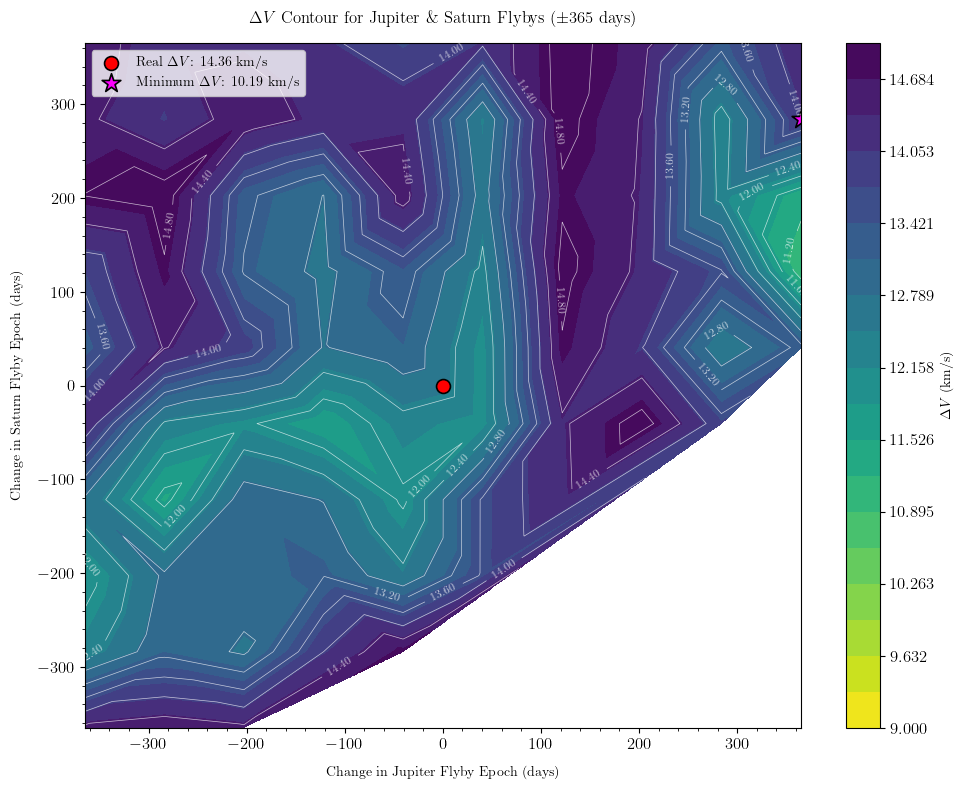

In [84]:
# Create a grid for the contour plot
max_deltav_threshold = 15  # km/s (adjust as needed)
valid_indices = [i for i in range(len(deltaV_values)) if deltaV_values[i] < max_deltav_threshold]

# Extract valid data
valid_jupiter_mjd = [jupiter_flyby_mjd_change_in_time[i] for i in valid_indices]
valid_saturn_mjd = [saturn_flyby_mjd_change_in_time[i] for i in valid_indices]
valid_deltaV = [deltaV_values[i] for i in valid_indices]

# Grid sizes
jupiter_range = np.linspace(min(valid_jupiter_mjd), max(valid_jupiter_mjd), 1000)
saturn_range = np.linspace(min(valid_saturn_mjd), max(valid_saturn_mjd), 1000)

# Create meshgrid
X, Y = np.meshgrid(jupiter_range, saturn_range)

# Interpolate deltaV values to the grid using linear interpolation
Z = griddata((valid_jupiter_mjd, valid_saturn_mjd), valid_deltaV, (X, Y), method='linear')

# Create the contour plot
fig, ax = plt.subplots(figsize=(10, 8))

# LaTeX-style text and font for better readability
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Set up a colormap that emphasizes the minimum Delta-V
cmap = plt.cm.viridis_r
norm = colors.Normalize(vmin=np.nanmin(Z), vmax=np.nanmax(Z))

# Plot the contour
# Define contour levels within the specified range
levels = np.linspace(9, max_deltav_threshold, 20)  # 20 levels from 9 to max threshold

# Filled contour plot
contour = ax.contourf(X, Y, Z, levels=levels, cmap=cmap, norm=colors.Normalize(vmin=9, vmax=max_deltav_threshold))

# Colorbar with correct limits
cbar = plt.colorbar(contour, ax=ax, label=r'$\Delta V$ (km/s)')
cbar.ax.tick_params(labelsize=12)

# Add contour lines
contour_lines = ax.contour(X, Y, Z, levels=10, colors='white', linewidths=0.5, alpha=0.7)
ax.clabel(contour_lines, inline=True, fontsize=8, fmt=r'%.2f')

# Plot key mission points
ax.scatter(0, 0, color='red', s=100, marker='o', edgecolors='black', linewidth=1.2, 
           label=r'Real $\Delta V$: {:.2f} km/s'.format(deltaV_REAL))

ax.scatter(date_flyby_jupiter_mjd_BRUTE_MIN - date_flyby_jupiter_mjd, 
           date_flyby_saturn_mjd_BRUTE_MIN - date_flyby_saturn_mjd, 
           color='fuchsia', s=200, marker='*', edgecolors='black', linewidth=1.2, 
           label=r'Minimum $\Delta V$: {:.2f} km/s'.format(deltaV_BRUTE_MIN))

# Set axis labels
ax.set_xlabel(r'Change in Jupiter Flyby Epoch (days)', labelpad=10)
ax.set_ylabel(r'Change in Saturn Flyby Epoch (days)', labelpad=10)
ax.set_title(r'$\Delta V$ Contour for Jupiter \& Saturn Flybys ($\pm$365 days)', pad=15)

# Improve grid and ticks
#ax.grid(which='major', color='#DDDDDD', linewidth=0.8)
#ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
ax.minorticks_on()

# Customize tick parameters
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=10)

plt.legend(loc='upper left')

# Adjust layout for better spacing
plt.tight_layout()
output_figures.save_file("voyager_II_brute_force_contour_2D.png", dpi=500, bbox_inches="tight")

plt.show()

Figure saved to: Voyager 2 - Figures/voyager_II_brute_force_contour_3D.png


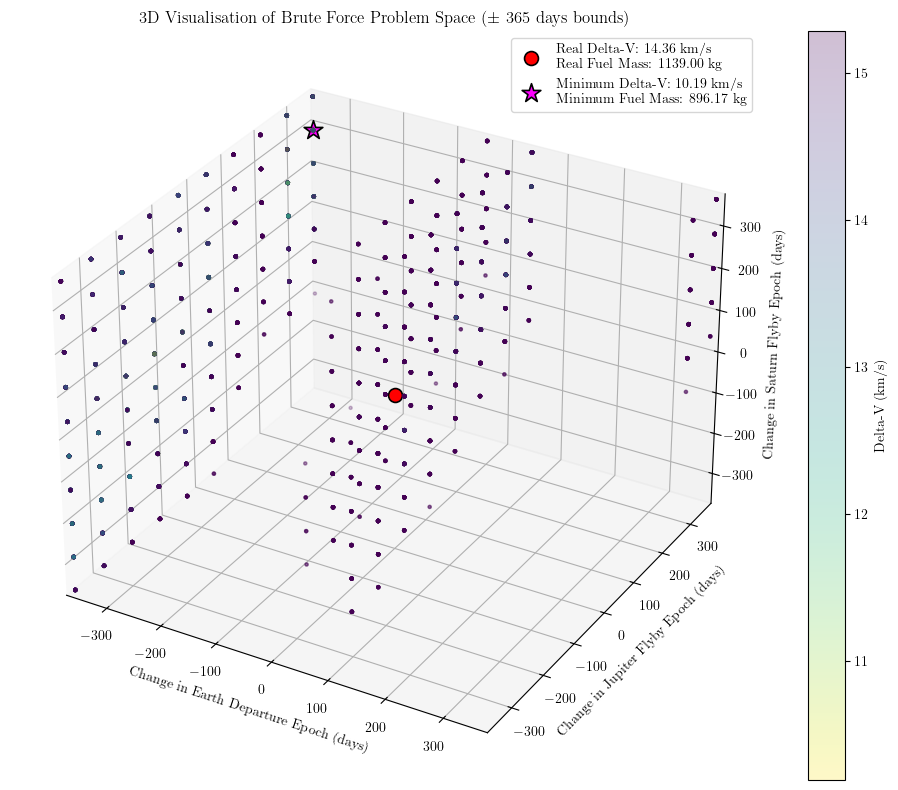

In [85]:
# Filter out any extreme values
max_deltav_threshold = 20  # km/s (adjust as needed)
valid_indices = [i for i in range(len(deltaV_values)) if deltaV_values[i] < max_deltav_threshold]

# Extract valid data
valid_departure_mjd = [departure_mjd_change_in_time[i] for i in valid_indices]
valid_jupiter_mjd = [jupiter_flyby_mjd_change_in_time[i] for i in valid_indices]
valid_saturn_mjd = [saturn_flyby_mjd_change_in_time[i] for i in valid_indices]
valid_deltaV = [deltaV_values[i] for i in valid_indices]

# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Create scatter plot with color based on delta-V 'viridis_r' 'plasma_r' 
scatter = ax.scatter(valid_departure_mjd, valid_jupiter_mjd, valid_saturn_mjd, 
                     c=valid_deltaV, cmap='viridis_r', s=5, alpha=0.25, 
                     norm=colors.Normalize(vmin=min(valid_deltaV), vmax=min(valid_deltaV) * 1.5))

# Highlight the delta-V points
ax.scatter([0], 
           [0], 
           [0], 
           color='red', s=100, marker='o', edgecolors='black', linewidth=1.2, 
           zorder=3,  # Higher zorder brings it to the front
           label=f'Real Delta-V: {deltaV_REAL:.2f} km/s\nReal Fuel Mass: {fuel_mass_REAL:.2f} kg')

ax.scatter([date_departure_mjd_BRUTE_MIN - date_departure_mjd], 
           [date_flyby_jupiter_mjd_BRUTE_MIN - date_flyby_jupiter_mjd], 
           [date_flyby_saturn_mjd_BRUTE_MIN - date_flyby_saturn_mjd], 
           color='fuchsia', s=200, marker='*', edgecolors='black', linewidth=1.2, 
           zorder=3,  # Higher zorder brings it to the front
           label=f'Minimum Delta-V: {deltaV_BRUTE_MIN:.2f} km/s\nMinimum Fuel Mass: {fuel_mass_BRUTE_MIN:.2f} kg')


date_flyby_saturn_mjd_BRUTE_MIN
# Add colorbar
cbar = plt.colorbar(scatter, ax=ax, label='Delta-V (km/s)')

# Set labels and title
ax.set_xlabel('Change in Earth Departure Epoch (days)')
ax.set_ylabel('Change in Jupiter Flyby Epoch (days)')
ax.set_zlabel('Change in Saturn Flyby Epoch (days)')
ax.set_title('3D Visualisation of Brute Force Problem Space ($\pm$ 365 days bounds)')

# Set axis limits
limit = 375
ax.set_xlim(-limit, limit)
ax.set_ylim(-limit, limit)
ax.set_zlim(-limit, limit)

# Add a legend
ax.legend(loc = "best")

# Show both plots
plt.tight_layout()
output_figures.save_file("voyager_II_brute_force_contour_3D.png", dpi=500, bbox_inches="tight")

#ax.view_init(elev=30, azim=45)  # Adjust elevation & azimuth for a better view
plt.show()

---
## Fmin Numerical Method

https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin.html

https://jasoncantarella.com/downloads/NelderMeadProof.pdf

In [87]:
dates_REAL

[43378.478599537164,
 44063.93739583343,
 44842.142326388974,
 46666.74984953692,
 47763.164305555634]

In [88]:
import numpy as np
import time
from scipy.optimize import fmin

# Initialize an empty list to store the iterations
iterations = []

# Initial guess for mission dates
initial_guess = np.array([dates_REAL])

def objective_function(dates):
    """
    Objective function to minimize Delta-V for the mission.
    Ensures dates stay within ±365 days of the initial guess.
    """
    # Unpack date variables
    date_departure_mjd, date_flyby_jupiter_mjd, date_flyby_saturn_mjd, date_flyby_uranus_mjd, date_flyby_neptune_mjd = dates

    # Define search bounds
    lower_bound = initial_guess - 365
    upper_bound = initial_guess + 365

    # Check if any date is out of bounds
    if np.any(dates < lower_bound) or np.any(dates > upper_bound):
        return np.inf  # Assign a high penalty for out-of-bounds solutions

    try:
        # Compute Delta-V for the given dates
        deltaV, fuel_mass, data_dict = find_deltaV_mission(
            date_departure_mjd, date_flyby_jupiter_mjd, 
            date_flyby_saturn_mjd, date_flyby_uranus_mjd, 
            date_flyby_neptune_mjd
        )

        # Store the iteration history
        iterations.append(dates.copy())

    except Exception as e:
        print(f"Error in simulation: {e}")
        return np.inf  # Assign a high penalty for failed evaluations

    return deltaV  # Minimize Delta-V

# Start timing the optimisation
start_time = time.time()

# Optimise using `fmin` (Simplex method)
optimal_dates = fmin(objective_function, initial_guess, disp=True, maxiter=2000)

# Extract the optimized departure and flyby dates
(
    date_departure_mjd_FMIN, date_flyby_jupiter_mjd_FMIN, 
    date_flyby_saturn_mjd_FMIN, date_flyby_uranus_mjd_FMIN, 
    date_flyby_neptune_mjd_FMIN
) = optimal_dates

# Compute Delta-V at optimissed dates
deltaV_FMIN, fuel_mass_FMIN, data_dict_FMIN = find_deltaV_mission(*optimal_dates)

# Display results
print(f"\nMinimum Delta-V: {deltaV_FMIN:.4f} km/s")
print(f"Optimal Departure Date (MJD): {date_departure_mjd_FMIN:.2f}")
print(f"Optimal Jupiter Flyby Date (MJD): {date_flyby_jupiter_mjd_FMIN:.2f}")
print(f"Optimal Saturn Flyby Date (MJD): {date_flyby_saturn_mjd_FMIN:.2f}")
print(f"Optimal Uranus Flyby Date (MJD): {date_flyby_uranus_mjd_FMIN:.2f}")
print(f"Optimal Neptune Flyby Date (MJD): {date_flyby_neptune_mjd_FMIN:.2f}")

# Convert MJD dates to calendar dates
print("\nIn calendar dates:")
print(f"Departure: {MJD_to_TT_calander_date(date_departure_mjd_FMIN)}")
print(f"Jupiter flyby: {MJD_to_TT_calander_date(date_flyby_jupiter_mjd_FMIN)}")
print(f"Saturn flyby: {MJD_to_TT_calander_date(date_flyby_saturn_mjd_FMIN)}")
print(f"Uranus flyby: {MJD_to_TT_calander_date(date_flyby_uranus_mjd_FMIN)}")
print(f"Neptune flyby: {MJD_to_TT_calander_date(date_flyby_neptune_mjd_FMIN)}")

# End timing
execution_time_FMIN = time.time() - start_time
print(f"\nExecution Time: {execution_time_FMIN:.4f} seconds")

Optimization terminated successfully.
         Current function value: 9.412354
         Iterations: 1039
         Function evaluations: 1722

Minimum Delta-V: 9.4124 km/s
Optimal Departure Date (MJD): 43388.33
Optimal Jupiter Flyby Date (MJD): 44087.64
Optimal Saturn Flyby Date (MJD): 44891.83
Optimal Uranus Flyby Date (MJD): 46541.79
Optimal Neptune Flyby Date (MJD): 47886.77

In calendar dates:
Departure: 1977-09-02 07:55:22.488
Jupiter flyby: 1979-08-02 15:17:24.802
Saturn flyby: 1981-10-14 20:01:54.751
Uranus flyby: 1986-04-21 18:55:05.762
Neptune flyby: 1989-12-26 18:34:26.752

Execution Time: 7.9390 seconds


In [89]:
# # Start timing the optimisation
# start_time = time.time()

# # Optimise using `fmin` (Simplex method)
# optimal_dates = fmin(objective_function, optimal_dates , disp=True)

# # Extract the optimized departure and flyby dates
# (
#     date_departure_mjd_FMIN, date_flyby_jupiter_mjd_FMIN, 
#     date_flyby_saturn_mjd_FMIN, date_flyby_uranus_mjd_FMIN, 
#     date_flyby_neptune_mjd_FMIN
# ) = optimal_dates

# # Compute Delta-V at optimissed dates
# deltaV_FMIN, fuel_mass_FMIN, data_dict_FMIN = find_deltaV_mission(*optimal_dates)

# # Display results
# print(f"\nMinimum Delta-V: {deltaV_FMIN:.4f} km/s")
# print(f"Optimal Departure Date (MJD): {date_departure_mjd_FMIN:.2f}")
# print(f"Optimal Jupiter Flyby Date (MJD): {date_flyby_jupiter_mjd_FMIN:.2f}")
# print(f"Optimal Saturn Flyby Date (MJD): {date_flyby_saturn_mjd_FMIN:.2f}")
# print(f"Optimal Uranus Flyby Date (MJD): {date_flyby_uranus_mjd_FMIN:.2f}")
# print(f"Optimal Neptune Flyby Date (MJD): {date_flyby_neptune_mjd_FMIN:.2f}")

# # Convert MJD dates to calendar dates
# print("\nIn calendar dates:")
# print(f"Departure: {MJD_to_TT_calander_date(date_departure_mjd_FMIN)}")
# print(f"Jupiter flyby: {MJD_to_TT_calander_date(date_flyby_jupiter_mjd_FMIN)}")
# print(f"Saturn flyby: {MJD_to_TT_calander_date(date_flyby_saturn_mjd_FMIN)}")
# print(f"Uranus flyby: {MJD_to_TT_calander_date(date_flyby_uranus_mjd_FMIN)}")
# print(f"Neptune flyby: {MJD_to_TT_calander_date(date_flyby_neptune_mjd_FMIN)}")

# # End timing
# execution_time_FMIN = time.time() - start_time
# print(f"\nExecution Time: {execution_time_FMIN:.4f} seconds")

In [90]:
#iterations

In [91]:
deltaV_FMIN, fuel_mass_FMIN, data_dict_FMIN = find_deltaV_mission(date_departure_mjd_FMIN, date_flyby_jupiter_mjd_FMIN, date_flyby_saturn_mjd_FMIN, 
                                                  date_flyby_uranus_mjd_FMIN, date_flyby_neptune_mjd_FMIN)
deltaV_FMIN, fuel_mass_FMIN, data_dict_FMIN

(9.412354252811033,
 844.0943192792565,
 {'deltaV_injection (km/s)': 9.412354231781963,
  'deltaV_jupiter (km/s)': 2.1027979357768345e-08,
  'deltaV_saturn (km/s)': 4.547473508864641e-13,
  'deltaV_uranus (km/s)': 6.359357485052897e-13,
  'rp_jupiter (km)': 799386.3999994716,
  'rp_saturn (km)': 175111.02199466518,
  'rp_uranus (km)': 120973.6693789514,
  'tof (days)': 4498.443799353488})

In [92]:
print("Earth-Jupiter:",date_flyby_jupiter_mjd_FMIN - date_departure_mjd_FMIN,"days")
print("Jupiter-Saturn:",date_flyby_saturn_mjd_FMIN - date_flyby_jupiter_mjd_FMIN,"days")
print("Saturn-Uranus:",date_flyby_uranus_mjd_FMIN - date_flyby_saturn_mjd_FMIN,"days")
print("Uranus-Neptune:",date_flyby_neptune_mjd_FMIN - date_flyby_uranus_mjd_FMIN,"days")

Earth-Jupiter: 699.3069712262368 days
Jupiter-Saturn: 804.197568851625 days
Saturn-Uranus: 1649.953599661756 days
Uranus-Neptune: 1344.9856596138707 days


In [93]:
dates_list_FMIN = [date_departure_mjd_FMIN, date_flyby_jupiter_mjd_FMIN, 
                   date_flyby_saturn_mjd_FMIN, date_flyby_uranus_mjd_FMIN,
                  date_flyby_neptune_mjd_FMIN]
dates_list_FMIN

[43388.33012139137,
 44087.63709261761,
 44891.834661469235,
 46541.78826113099,
 47886.77392074486]

In [94]:
change_in_dates_list_FMIN = [
    (date_departure_mjd - date_departure_mjd_FMIN),
    (date_flyby_jupiter_mjd - date_flyby_jupiter_mjd_FMIN),
    (date_flyby_saturn_mjd - date_flyby_saturn_mjd_FMIN),
    (date_flyby_uranus_mjd - date_flyby_uranus_mjd_FMIN),
    (date_flyby_neptune_mjd - date_flyby_neptune_mjd_FMIN)
]
change_in_dates_list_FMIN

[-9.85152185420884,
 -23.699696784176922,
 -49.69233508026082,
 124.96158840593125,
 -123.60961518922704]

In [95]:
date_departure_FMIN = MJD_to_TT_calander_date(date_departure_mjd_FMIN)
date_flyby_jupiter_FMIN =  MJD_to_TT_calander_date(date_flyby_jupiter_mjd_FMIN)
date_flyby_saturn_FMIN = MJD_to_TT_calander_date(date_flyby_saturn_mjd_FMIN)
date_flyby_uranus_FMIN = MJD_to_TT_calander_date(date_flyby_uranus_mjd_FMIN)
date_flyby_neptune_FMIN = MJD_to_TT_calander_date(date_flyby_neptune_mjd_FMIN)

print("Date of Departure (Min):", date_departure_FMIN)
print("Date of Jupiter Flyby (Min):", date_flyby_jupiter_FMIN)
print("Date of Saturn Flyby (Min):", date_flyby_saturn_FMIN)
print("Date of Uranus Flyby (Min):", date_flyby_uranus_FMIN)  # Fixed
print("Date of Neptune Flyby (Min):", date_flyby_neptune_FMIN)  # Fixed

Date of Departure (Min): 1977-09-02 07:55:22.488
Date of Jupiter Flyby (Min): 1979-08-02 15:17:24.802
Date of Saturn Flyby (Min): 1981-10-14 20:01:54.751
Date of Uranus Flyby (Min): 1986-04-21 18:55:05.762
Date of Neptune Flyby (Min): 1989-12-26 18:34:26.752


### Contour Graph of Problem Space

Figure saved to: Voyager 2 - Figures/voyager_II_fmin_contour_3D.png


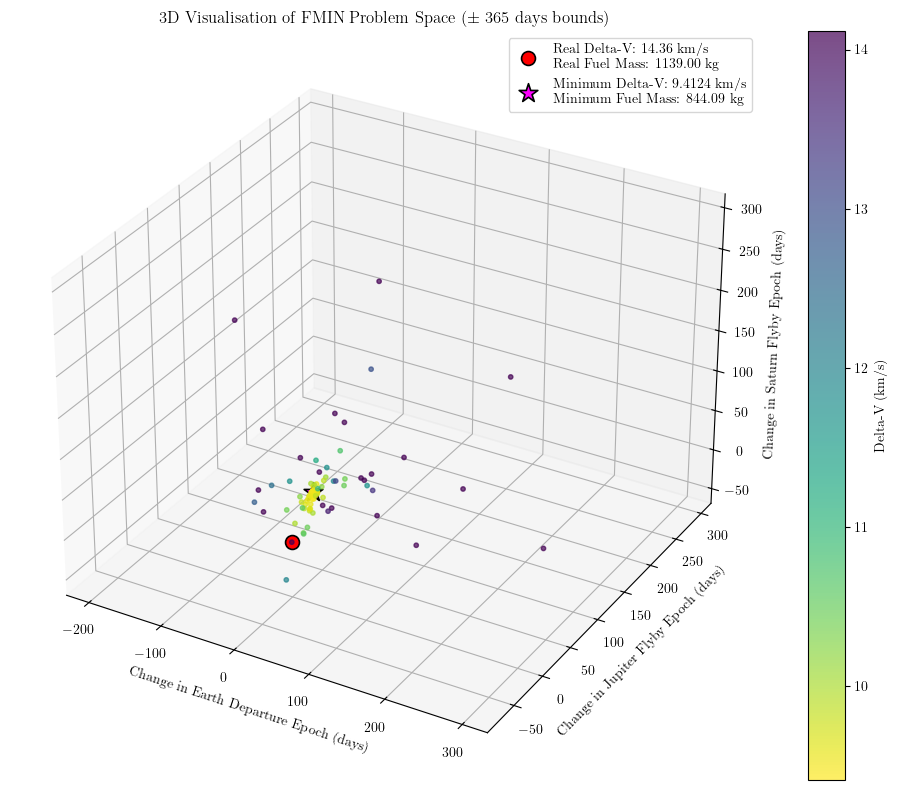

In [97]:
# Extract the dates from the iterations list
departure_dates_FMIN = np.array([iter[0] for iter in iterations])
jupiter_flyby_dates_FMIN = np.array([iter[1] for iter in iterations])
saturn_flyby_dates_FMIN = np.array([iter[2] for iter in iterations])

# Calculate the corresponding deltaV values for the iterations
deltaV_values_FMIN = []
for dates in iterations:
    try:
        deltaV, _, _ = find_deltaV_mission(*dates)
    except Exception:
        deltaV_values_FMIN.append(np.inf)
        continue
    deltaV_values_FMIN.append(deltaV)

# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Scatter plot with color based on deltaV
scatter = ax.scatter(departure_dates_FMIN - date_departure_mjd, jupiter_flyby_dates_FMIN - date_flyby_jupiter_mjd, saturn_flyby_dates_FMIN - date_flyby_saturn_mjd, 
                     c=deltaV_values_FMIN, cmap='viridis_r', s=10, alpha=0.7, 
                     norm=plt.Normalize(vmin=min(deltaV_values_FMIN), vmax=min(deltaV_values_FMIN) * 1.5))

#ax.plot(departure_dates_FMIN - date_departure_mjd, jupiter_flyby_dates_FMIN - date_flyby_jupiter_mjd, saturn_flyby_dates_FMIN - date_flyby_saturn_mjd,
#        linestyle='-', color='g', markersize=6, linewidth=0.5, alpha=0.5)

ax.scatter([0], 
           [0], 
           [0], 
           color='red', s=100, marker='o', edgecolors='black', linewidth=1.2, 
           zorder=3,  # Higher zorder brings it to the front
           label=f'Real Delta-V: {deltaV_REAL:.2f} km/s\nReal Fuel Mass: {fuel_mass_REAL:.2f} kg')

ax.scatter(date_departure_mjd_FMIN - date_departure_mjd, 
           date_flyby_jupiter_mjd_FMIN - date_flyby_jupiter_mjd, 
           date_flyby_saturn_mjd_FMIN - date_flyby_saturn_mjd, 
           color='fuchsia', s=200, marker='*', edgecolors='black', linewidth=1.2, 
           zorder=3,  # Higher zorder brings it to the front
           label=f'Minimum Delta-V: {deltaV_FMIN:.4f} km/s\nMinimum Fuel Mass: {fuel_mass_FMIN:.2f} kg')


# Add colorbar
cbar = plt.colorbar(scatter, ax=ax, label='Delta-V (km/s)')

# Set labels and title
ax.set_xlabel('Change in Earth Departure Epoch (days)')
ax.set_ylabel('Change in Jupiter Flyby Epoch (days)')
ax.set_zlabel('Change in Saturn Flyby Epoch (days)')
ax.set_title('3D Visualisation of FMIN Problem Space ($\pm$ 365 days bounds)')

ax.legend(loc = "best")

# Set axis limits
# limit = 375
# ax.set_xlim(-limit, limit)
# ax.set_ylim(-limit, limit)
# ax.set_zlim(-limit, limit)

# Show the plot
plt.tight_layout()
output_figures.save_file("voyager_II_fmin_contour_3D.png", dpi=500, bbox_inches="tight")

plt.show()

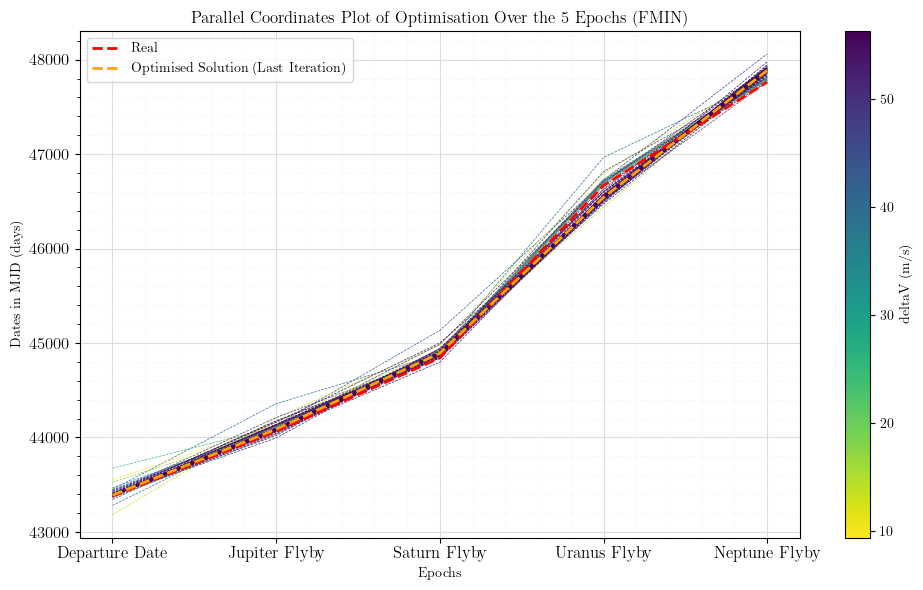

In [98]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from matplotlib.colors import Normalize

# Convert the iterations into a pandas DataFrame
df = pd.DataFrame(iterations, columns=['Departure Date', 'Jupiter Flyby', 'Saturn Flyby', 'Uranus Flyby', 'Neptune Flyby'])

# Calculate the corresponding deltaV values for the iterations
deltaV_values_FMIN = []
for dates in iterations:
    try:
        deltaV, _, _ = find_deltaV_mission(*dates)  # Assuming find_deltaV_mission function is defined
    except Exception:
        deltaV_values_FMIN.append(np.inf)
        continue
    deltaV_values_FMIN.append(deltaV)

# Create an index for the iterations and add deltaV values to the DataFrame
df['deltaV'] = deltaV_values_FMIN
df['Iteration'] = df.index

# Set up the colour map for the lines based on deltaV values
norm = Normalize(vmin=np.min(deltaV_values_FMIN), vmax=np.max(deltaV_values_FMIN))
colors = plt.cm.viridis(norm(deltaV_values_FMIN))

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting the parallel coordinates plot with dashed lines
for i, row in df.iterrows():
    ax.plot(df.columns[:-2], row[:-2], linestyle='--', linewidth=.5, color=colors[i])  # Use color based on deltaV

ax.plot(df.columns[:-2], dates_REAL, linestyle='--', color='red', linewidth=2, label='Real')  # Highlighted line

# Highlight the last iteration
last_iteration = df.iloc[-1]
ax.plot(df.columns[:-2], last_iteration[:-2], linestyle='--', color='orange', linewidth=2, label='Optimised Solution (Last Iteration)')  # Highlighted line

# Add colour bar for deltaV
sm = plt.cm.ScalarMappable(cmap='viridis_r', norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, label='deltaV (m/s)')

# Set title and labels
ax.set_title('Parallel Coordinates Plot of Optimisation Over the 5 Epochs (FMIN)')
ax.set_xlabel('Epochs')
ax.set_ylabel('Dates in MJD (days)')

# Improve grid and ticks
ax.grid(which='major', color='#DDDDDD', linewidth=0.8)
ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
ax.minorticks_on()

# Customize tick parameters
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=10)

ax.tick_params(axis='x', which='minor', length=0)

# Add legend for last iteration
ax.legend()

# Adjust layout for tightness
plt.tight_layout()

# Show the plot
plt.show()

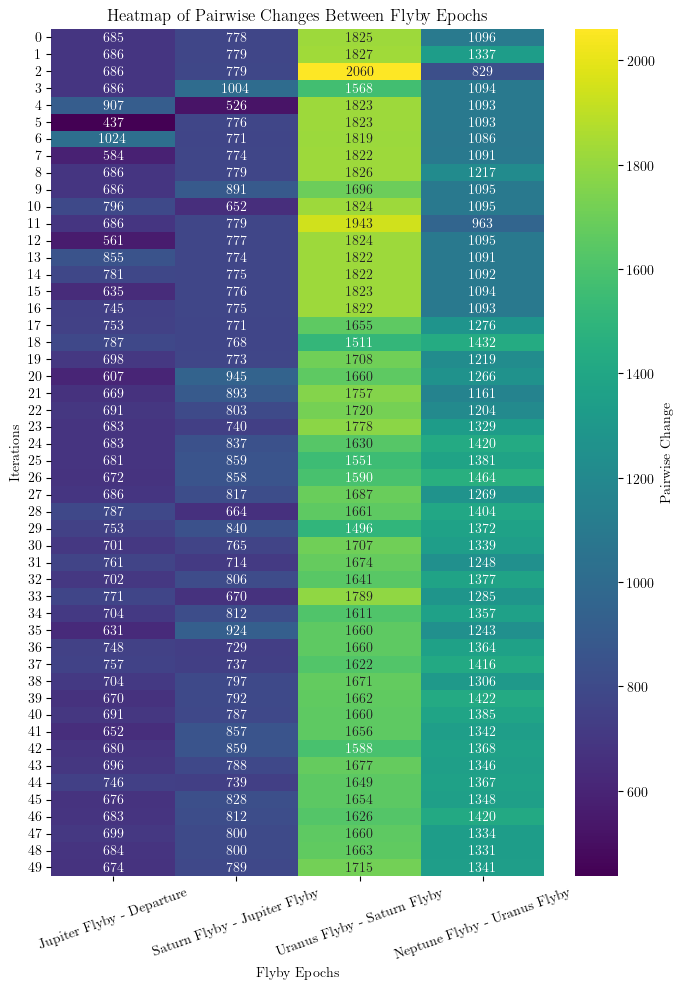

In [99]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df_chosen = df.head(50)

# Select relevant columns
df_pairwise = df_chosen[['Departure Date', 'Jupiter Flyby', 'Saturn Flyby', 'Uranus Flyby', 'Neptune Flyby']]

# Compute pairwise differences
pairwise_changes = df_pairwise.diff(axis=1)

# Rename columns to match desired format
pairwise_changes.columns = [
    'Departure',
    'Jupiter Flyby - Departure',
    'Saturn Flyby - Jupiter Flyby',
    'Uranus Flyby - Saturn Flyby',
    'Neptune Flyby - Uranus Flyby'
]

pairwise_changes = pairwise_changes.iloc[:, 1:]

# Compute the absolute values of the differences
#pairwise_changes = pairwise_changes.abs()

def format_annotation(val):
    if val < 1e-3:
        return f"{val:.2e}"  
    else:
        return f"{int(val)}"

# Create a heatmap of pairwise changes for the last 50 iterations
# Plot the data
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

fig, ax = plt.subplots(figsize=(7, 10))
sns.heatmap(pairwise_changes, annot=True, fmt=".0f", cmap='viridis', cbar_kws={'label': 'Pairwise Change'}, annot_kws={"size": 10})

# Update annotations with custom format
for text in plt.gca().texts:
    text.set_text(format_annotation(float(text.get_text())))

plt.xticks(rotation=20)
plt.yticks(rotation=0)

plt.title('Heatmap of Pairwise Changes Between Flyby Epochs')
plt.xlabel('Flyby Epochs')
plt.ylabel('Iterations')

#ax.minorticks_on()
#ax.tick_params(axis='both', which='major', labelsize=12)
#ax.tick_params(axis='both', which='minor', labelsize=10)

ax.tick_params(axis='x', which='minor', length=0)

# Show the plot
plt.tight_layout()
plt.show()

In [100]:
df.columns[:]

Index(['Departure Date', 'Jupiter Flyby', 'Saturn Flyby', 'Uranus Flyby',
       'Neptune Flyby', 'deltaV', 'Iteration'],
      dtype='object')

In [101]:
[(date_departure_mjd - date_departure_mjd_FMIN), 
 (date_flyby_jupiter_mjd - date_flyby_jupiter_mjd_FMIN), 
 (date_flyby_saturn_mjd - date_flyby_saturn_mjd_FMIN), 
 (date_flyby_uranus_mjd - date_flyby_uranus_mjd_FMIN), 
 (date_flyby_neptune_mjd - date_flyby_neptune_mjd_FMIN)]

[-9.85152185420884,
 -23.699696784176922,
 -49.69233508026082,
 124.96158840593125,
 -123.60961518922704]

---
## Genetic Algorithm (GA)

In [103]:
change_in_time_days = 365

min_departure_date = date_departure_mjd - change_in_time_days 
max_departure_date = date_departure_mjd + change_in_time_days

min_flyby_jupiter = date_flyby_jupiter_mjd - change_in_time_days
max_flyby_jupiter = date_flyby_jupiter_mjd + change_in_time_days

min_flyby_saturn = date_flyby_saturn_mjd - change_in_time_days 
max_flyby_saturn = date_flyby_saturn_mjd + change_in_time_days  

min_flyby_uranus = date_flyby_uranus_mjd - change_in_time_days 
max_flyby_uranus = date_flyby_uranus_mjd + change_in_time_days 

min_flyby_neptune = date_flyby_neptune_mjd - change_in_time_days 
max_flyby_neptune = date_flyby_saturn_mjd + change_in_time_days 

### Step 1: Generate Initial Population

In [105]:
# Step 1: Generate Initial Population
def initial_population(n_population):
    # Generates initial population within mission constraints.
    population = []
    population.append(dates_REAL)

    # Add interval to generate population
    for num in range(n_population-1):
        date_departure_pop = random.uniform(min_departure_date, max_departure_date)
        date_flyby_jupiter_pop = random.uniform(min_flyby_jupiter, max_flyby_jupiter)
        date_flyby_saturn_pop = random.uniform(min_flyby_saturn, max_flyby_saturn)
        date_flyby_uranus_pop = random.uniform(min_flyby_uranus, max_flyby_uranus)
        date_flyby_neptune_pop = random.uniform(min_flyby_neptune, max_flyby_neptune)

        # Ensure chronological order of mission events
        dates_ordered = np.sort([date_departure_pop, date_flyby_jupiter_pop, date_flyby_saturn_pop, 
                           date_flyby_uranus_pop, date_flyby_neptune_pop])

        population.append(dates_ordered)
    
    return population

initial_population(5)

[[43378.478599537164,
  44063.93739583343,
  44842.142326388974,
  46666.74984953692,
  47763.164305555634],
 array([43442.43384155, 43723.75113014, 44984.59220914, 46072.29292495,
        46963.24282442]),
 array([43128.1480892 , 43787.20290003, 45059.42477589, 46132.4085776 ,
        46754.94010911]),
 array([43500.70021043, 43846.95961422, 44725.40710313, 45765.66901324,
        46374.37533129]),
 array([43027.6995927 , 44017.80466938, 44996.06297748, 46955.68680532,
        47011.07819148])]

### Step 2: Evaluation [Fitness Function (Objective Function)]

In [107]:
# Step 2: Evaluation - Fitness Function (Objective Function)
def fitness(individual):
    # Evaluates fitness based on deltaV_total minimisation
    try:
        date_departure_mjd, date_flyby_jupiter_mjd, date_flyby_saturn_mjd, date_flyby_uranus_mjd, date_flyby_neptune_mjd = individual
        deltaV, fuel_mass, data_dict = find_deltaV_mission(*individual)
    except Exception:
        deltaV = 1e6  # Assign a large penalty for infeasible solutions

    return 1 / (deltaV + 1e-6)  # Avoid division by zero

### Step 3: Sort Population by Fitness

In [109]:
def sort_population_by_fitness(population, fitness_scores, n_population):
    sorted_indices = np.argsort(fitness_scores)[::-1]  # Sort by highest fitness
    population = [population[i] for i in sorted_indices[:n_population]] # Ensures length population is 'n_population' 
    return population   

### Step 4: Elitism (Optional)

In [111]:
def elitism(population, n_elite):
    elite_individuals = population[:n_elite]
    return elite_individuals

### Step 5: Selection

#### Tournament Selection

In [114]:
def tournament_selection(population, fitness_scores, tournament_size=3):
    # Select random individuals for the tournament
    selected_indices = np.random.choice(len(population), tournament_size, replace=False)
    
    # Find the best individual in the tournament
    tournament_fitness = [fitness_scores[i] for i in selected_indices]
    winner_idx = selected_indices[np.argmax(tournament_fitness)]
    
    return population[winner_idx]

#### Roulette Wheel Selection

In [116]:
def roulette_wheel_selection(population, fitness_values):
    # Calculate the normalised selection probability for each individual
    selection_prob = fitness_values / sum(fitness_values)
    # Calculate cumulative sum of fitness probabilities
    cum_sum = selection_prob.cumsum()
    # Generate a random number between 0 and 1
    r = random.random()
    # Find the first index where cumulative sum exceeds random number
    selected_index = np.where(cum_sum >= r)[0][0]
    return population[selected_index]

pop = initial_population(20)
# Evaluate fitness function
fitness_scores = np.array([fitness(ind) for ind in pop])        
# Sorts population by fitness value
pop = sort_population_by_fitness(pop, fitness_scores, 20)

roulette_wheel_selection(pop, fitness_scores)

[43378.478599537164,
 44063.93739583343,
 44842.142326388974,
 46666.74984953692,
 47763.164305555634]

### Step 6: Crossover

#### Simulated Binary Crossover (SBX)

https://pymoo.org/operators/crossover.html

In [119]:
def sbx_crossover(parent_1, parent_2, eta=1.5):
    offspring_1 = parent_1[:]
    offspring_2 = parent_2[:]
    
    for i in range(len(parent_1)):  
        u = random.random()
        if u <= 0.5:
            beta = (2 * u) ** (1 / (eta + 1))
        else:
            beta = (1 / (2 * (1 - u))) ** (1 / (eta + 1))

        # Generate offspring
        offspring_1[i] = 0.5 * ((1 + beta) * parent_1[i] + (1 - beta) * parent_2[i])
        offspring_2[i] = 0.5 * ((1 - beta) * parent_1[i] + (1 + beta) * parent_2[i])

    # Ensure chronological order (if values represent time-based sequences)
    # offspring_1 = np.sort(offspring_1)
    # offspring_2 = np.sort(offspring_2)

    return offspring_1, offspring_2

### Step 7: Mutation (Random Perturbations)

In [121]:
def gaussian_mutation(individual):
    # Create a copy to avoid modifying the original
    mutated = individual.copy()
    temp = mutated
    
    # Define bounds for each parameter
    bounds = [
        [min_departure_date, max_departure_date],
        [min_flyby_jupiter, max_flyby_jupiter],
        [min_flyby_saturn, max_flyby_saturn],
        [min_flyby_uranus, max_flyby_uranus],
        [min_flyby_neptune, max_flyby_neptune],
    ]
    
    # Select random index to mutate
    index = random.randint(0, 4)
    
    # Calculate parameter range
    param_range = bounds[index][1] - bounds[index][0]
    
    # Apply Gaussian mutation with standard deviation proportional to parameter range
    sigma = 0.05 * param_range  # 5% of the parameter range
    delta = random.gauss(0, sigma)
    mutated[index] += delta
    
    # Ensure value stays within bounds
    if mutated[index] < bounds[index][0] or mutated[index] > bounds[index][1]:
        mutated[index] = temp[index]
    
    # Ensure sequential order
    # mutated = np.sort(mutated)
    
    return mutated

### Step 8: Running GA

1. Initialise population
2. Sort population
3. Start Loop
4. Evaluate fitness
5. Select parents (roulette wheel)
6. Crossover (SBX or copy)
7. Mutation
8. Combine Offspring & Elite Individuals
9. Filter for constraints
10. Sort & truncate population 
11. Elitism (store best individuals)
12. Does it satisfy termination condition
13. If NO, then repeat loop. If YES, end loop
14. Store best (optimal) individual solution

In [123]:
def run_genetic_algorithm(n_population, n_elite, crossover_per, mutation_per, n_generations, population_per_generation):
    
    population = initial_population(n_population) # Generate initial population

    # Evaluate fitness function
    fitness_scores_temp = np.array([fitness(ind) for ind in population])
    # Sorts population by fitness value
    population_temp = sort_population_by_fitness(population, fitness_scores_temp, n_population)
    
    population_per_generation.append(population_temp)
    elite_individuals = []
    
    for generation in range(0, n_generations):
        start_time = time.time()
        # Evaluate fitness function
        fitness_scores = np.array([fitness(ind) for ind in population])
            
        # Sorts population by fitness value
        population = sort_population_by_fitness(population, fitness_scores, n_population)

        # Print progress
        best_individual = population[0]
        best_deltaV, best_fuel_mass, _ = find_deltaV_mission(*best_individual)
        print(f"Generation {generation}: Best Delta-V = {best_deltaV:.6f} km/s, Fitness = {fitness(best_individual):.6f}")
                
        # Apply elitism - preserve the best individuals
        if n_elite != 0:
            elite_individuals = elitism(population, n_elite)
        
        # Select parents for potential crossover - select enough for the whole population
        parents_list = []
        for i in range(n_population):
            parents_list.append(tournament_selection(population, fitness_scores))

        # Perform crossover with crossover probability
        offspring_list = []
        for i in range(0, len(parents_list) - 1, 2):
            # Apply crossover based on crossover probability
            if random.random() < crossover_per:
                offspring_1, offspring_2 = sbx_crossover(parents_list[i], parents_list[i+1])
            else:
                # If no crossover, children are exact copies of parents
                offspring_1, offspring_2 = parents_list[i][:], parents_list[i+1][:]
            
            offspring_list.extend([offspring_1, offspring_2])

        # Perform mutation
        for i in range(len(offspring_list)):
            if random.random() < mutation_per:
                    offspring_list[i] = gaussian_mutation(offspring_list[i])
        
        # Combine elite individuals, parents and offspring
        mixed_population = offspring_list + elite_individuals
        
        # Filter solutions that meet the mission constraints
        mixed_population = [
            ind for ind in mixed_population 
            if np.abs(ind[0] - date_departure_mjd) <= change_in_time_days 
            and np.abs(ind[1] - date_flyby_jupiter_mjd) <= change_in_time_days 
            and np.abs(ind[2] - date_flyby_saturn_mjd) <= change_in_time_days
            and np.abs(ind[3] - date_flyby_uranus_mjd) <= change_in_time_days
            and np.abs(ind[4] - date_flyby_neptune_mjd) <= change_in_time_days
        ]
        
        # Ensure population is not empty (if all individuals were filtered out)
        if not mixed_population:
            mixed_population = offspring_list + elite_individuals # Restore full population if filtering removed all

        # Ensure population size remains constant (selection 'n_population' best individuals)
        fitness_scores = np.array([fitness(ind) for ind in mixed_population])
        population = sort_population_by_fitness(mixed_population, fitness_scores, n_population)

        # Store current population
        population_per_generation.append(population)

        end_time = time.time()
        #print(end_time - start_time)
    
    # Return the best-found solution
    best_individual = population[0]
    best_list = best_deltaV, best_fuel_mass, best_data = find_deltaV_mission(*best_individual)
    print(f"Generation {n_generations}: Best Delta-V = {best_deltaV:.6f} km/s, Fitness = {fitness(best_individual):.6f}")
    
    print("\nFinal Optimised Solution:")
    print(f"Departure Date (MJD): {best_individual[0]:.2f}")
    print(f"Jupiter Flyby Date (MJD): {best_individual[1]:.2f}")
    print(f"Saturn Flyby Date (MJD): {best_individual[2]:.2f}")
    print(f"Uranus Flyby Date (MJD): {best_individual[3]:.2f}")
    print(f"Neptune Flyby Date (MJD): {best_individual[4]:.2f}")
    print(f"Total deltaV: {best_deltaV:.6f} km/s")
    
    return best_individual, best_list, population_per_generation

In [124]:
# n_population = 2000
# n_elite = 5
# crossover_per = 0.9
# mutation_per = 0.35
# n_generations = 25

n_population = 2500
n_elite = 10
crossover_per = 0.9
mutation_per = 0.3
n_generations = 50

In [125]:
%%time

if global_flag:
    # Start timing
    start_time = time.time()
    
    # Run the Genetic Algorithm
    best_individual, best_mission_data, population_per_generation = run_genetic_algorithm(n_population, n_elite, crossover_per, mutation_per, n_generations, [])
    print()
    # End timing
    end_time = time.time()
    execution_time_GA = end_time - start_time
    print(f"\nExecution Time: {execution_time_GA:.4f} seconds\n")

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs


In [126]:
if global_flag:
    filename_GA = output_pickle.get_path("ga_results_V2.pkl")
    
    results_GA = {
        "Best Individual": best_individual,
        "Best Mission Data": best_mission_data,
        "Population Per Generation": population_per_generation,
        "execution_time_GA": execution_time_GA
    }
    
    with open(filename_GA, "wb") as f:
        pickle.dump(results_GA, f)

In [127]:
filename_GA = output_pickle.get_path("ga_results_V2.pkl")

with open(filename_GA, "rb") as f:
    data = pickle.load(f)

best_individual = data["Best Individual"]
best_mission_data = data["Best Mission Data"]
population_per_generation = data["Population Per Generation"]
execution_time_GA = data["execution_time_GA"]

if not global_flag:
    for gen in range(len(population_per_generation)):
        best_individual = population_per_generation[gen][0]
        best_deltaV, best_fuel_mass, _ = find_deltaV_mission(*best_individual)
        print(f"Generation {gen}: Best Delta-V = {best_deltaV:.6f} km/s, Fitness = {fitness(best_individual):.6f}")

    # Return the best-found solution
    best_individual = population_per_generation[-1][0]
    best_list = best_deltaV, best_fuel_mass, best_data = find_deltaV_mission(*best_individual)
    print(f"Generation {n_generations}: Best Delta-V = {best_deltaV:.6f} km/s, Fitness = {fitness(best_individual):.6f}")
    
    print("\nFinal Optimised Solution:")
    print(f"Departure Date (MJD): {best_individual[0]:.2f}")
    print(f"Jupiter Flyby Date (MJD): {best_individual[1]:.2f}")
    print(f"Saturn Flyby Date (MJD): {best_individual[2]:.2f}")
    print(f"Total deltaV: {best_deltaV:.6f} km/s")

    print(f"\nExecution Time: {execution_time_GA:.4f} seconds\n")

Generation 0: Best Delta-V = 37.709450 km/s, Fitness = 0.026519
Generation 1: Best Delta-V = 14.362478 km/s, Fitness = 0.069626
Generation 2: Best Delta-V = 11.649274 km/s, Fitness = 0.085842
Generation 3: Best Delta-V = 10.601890 km/s, Fitness = 0.094323
Generation 4: Best Delta-V = 9.890266 km/s, Fitness = 0.101110
Generation 5: Best Delta-V = 9.744876 km/s, Fitness = 0.102618
Generation 6: Best Delta-V = 9.548412 km/s, Fitness = 0.104729
Generation 7: Best Delta-V = 9.512533 km/s, Fitness = 0.105124
Generation 8: Best Delta-V = 9.512533 km/s, Fitness = 0.105124
Generation 9: Best Delta-V = 9.449632 km/s, Fitness = 0.105824
Generation 10: Best Delta-V = 9.449632 km/s, Fitness = 0.105824
Generation 11: Best Delta-V = 9.427138 km/s, Fitness = 0.106077
Generation 12: Best Delta-V = 9.422336 km/s, Fitness = 0.106131
Generation 13: Best Delta-V = 9.381279 km/s, Fitness = 0.106595
Generation 14: Best Delta-V = 9.381279 km/s, Fitness = 0.106595
Generation 15: Best Delta-V = 9.381279 km/s, F

In [128]:
best_solutions_per_generation = [element[0] for element in population_per_generation]
best_solutions_per_generation, len(best_solutions_per_generation)

([array([43443.76874244, 44039.05421941, 44637.57577965, 45319.88481125,
         46284.49398829]),
  [43378.478599537164,
   44063.93739583343,
   44842.142326388974,
   46666.74984953692,
   47763.164305555634],
  [43380.77951727805,
   44107.70042570419,
   44926.49803246876,
   46698.07377182713,
   47962.934515209054],
  [43380.400285864875,
   44108.38634894993,
   44923.48556167665,
   46695.6565872324,
   48075.21551587626],
  [43387.25792566488,
   44101.90374871451,
   44922.180443175326,
   46683.173877008565,
   48090.041501821375],
  [43381.96987273972,
   44117.023943234126,
   44948.86535134808,
   46673.01537129662,
   48087.4669076794],
  [43389.600726734854,
   44110.68995528259,
   44946.15222815048,
   46641.308860975885,
   48016.05006767387],
  [43389.265420324926,
   44107.944566801394,
   44946.22316179819,
   46636.04322872249,
   48026.53337676281],
  [43389.265420324926,
   44107.944566801394,
   44946.22316179819,
   46636.04322872249,
   48026.53337676281],

In [129]:
dates_REAL

[43378.478599537164,
 44063.93739583343,
 44842.142326388974,
 46666.74984953692,
 47763.164305555634]

### GA Result Analysis

In [131]:
deltaV_GA, fuel_mass_GA, data_dict_GA = find_deltaV_mission(*best_individual)
deltaV_GA, fuel_mass_GA, data_dict_GA

(9.369043404617052,
 841.1377507832318,
 {'deltaV_injection (km/s)': 9.361080764998041,
  'deltaV_jupiter (km/s)': 0.0003318674548360434,
  'deltaV_saturn (km/s)': 0.00036609910977958293,
  'deltaV_uranus (km/s)': 0.007264673054395487,
  'rp_jupiter (km)': 922119.2855491277,
  'rp_saturn (km)': 209107.02952773124,
  'rp_uranus (km)': 150486.55636449813,
  'tof (days)': 4718.199138499811})

In [132]:
date_departure_mjd_GA = best_individual[0]
date_flyby_jupiter_mjd_GA = best_individual[1]
date_flyby_saturn_mjd_GA = best_individual[2]
date_flyby_uranus_mjd_GA = best_individual[3]
date_flyby_neptune_mjd_GA = best_individual[4]

print(f"Difference for date_departure: {date_departure_mjd_GA - date_departure_mjd}")
print(f"Difference for date_flyby_jupiter: {date_flyby_jupiter_mjd_GA - date_flyby_jupiter_mjd}")
print(f"Difference for date_flyby_saturn: {date_flyby_saturn_mjd_GA - date_flyby_saturn_mjd}")
print(f"Difference for date_flyby_uranus: {date_flyby_uranus_mjd_GA - date_flyby_uranus_mjd}")
print(f"Difference for date_flyby_neptune: {date_flyby_neptune_mjd_GA - date_flyby_neptune_mjd}\n")

change_in_dates_list_GA = [
    (date_departure_mjd - date_departure_mjd_GA),
    (date_flyby_jupiter_mjd - date_flyby_jupiter_mjd_GA),
    (date_flyby_saturn_mjd - date_flyby_saturn_mjd_GA),
    (date_flyby_uranus_mjd_GA - date_flyby_uranus_mjd),
    (date_flyby_neptune_mjd_GA - date_flyby_neptune_mjd)
]
change_in_dates_list_GA

Difference for date_departure: 10.406205081788357
Difference for date_flyby_jupiter: 52.726732880968484
Difference for date_flyby_saturn: 122.4597915942577
Difference for date_flyby_uranus: 25.45840140400105
Difference for date_flyby_neptune: 343.9196375631291



[-10.406205081788357,
 -52.726732880968484,
 -122.4597915942577,
 25.45840140400105,
 343.9196375631291]

In [133]:
print("Earth-Jupiter:",date_flyby_jupiter_mjd_GA - date_departure_mjd_GA,"days")
print("Jupiter-Saturn:",date_flyby_saturn_mjd_GA - date_flyby_jupiter_mjd_GA,"days")
print("Saturn-Uranus:",date_flyby_uranus_mjd_GA - date_flyby_saturn_mjd_GA,"days")
print("Uranus-Neptune:",date_flyby_neptune_mjd_GA - date_flyby_uranus_mjd_GA,"days")

Earth-Jupiter: 727.7793240954488 days
Jupiter-Saturn: 847.9379892688303 days
Saturn-Uranus: 1727.6061329576914 days
Uranus-Neptune: 1414.8756921778404 days


In [134]:
date_departure_GA = MJD_to_TT_calander_date(date_departure_mjd_GA)
date_flyby_jupiter_GA = MJD_to_TT_calander_date(date_flyby_jupiter_mjd_GA)
date_flyby_saturn_GA = MJD_to_TT_calander_date(date_flyby_saturn_mjd_GA)
date_flyby_uranus_GA = MJD_to_TT_calander_date(date_flyby_uranus_mjd_GA)
date_flyby_neptune_GA = MJD_to_TT_calander_date(date_flyby_neptune_mjd_GA)

print("Date of Departure (Min):", MJD_to_TT_calander_date(date_departure_mjd_GA))

print("Date of Jupiter Flyby (Min):", MJD_to_TT_calander_date(date_flyby_jupiter_mjd_GA))

print("Date of Saturn Flyby (Min):", MJD_to_TT_calander_date(date_flyby_saturn_mjd_GA))

print("Date of Uranus Flyby (Min):", MJD_to_TT_calander_date(date_flyby_uranus_mjd_GA))

print("Date of Neptune Flyby (Min):", MJD_to_TT_calander_date(date_flyby_neptune_mjd_GA))

[date_departure_GA, date_flyby_jupiter_GA, date_flyby_saturn_GA, date_flyby_uranus_GA, date_flyby_neptune_GA]

Date of Departure (Min): 1977-09-02 21:14:07.119
Date of Jupiter Flyby (Min): 1979-08-31 15:56:20.721
Date of Saturn Flyby (Min): 1981-12-26 14:27:02.994
Date of Uranus Flyby (Min): 1986-09-19 04:59:52.881
Date of Neptune Flyby (Min): 1990-08-04 02:00:52.685


['1977-09-02 21:14:07.119',
 '1979-08-31 15:56:20.721',
 '1981-12-26 14:27:02.994',
 '1986-09-19 04:59:52.881',
 '1990-08-04 02:00:52.685']

In [135]:
GA_list = [date_departure_mjd_GA, date_flyby_jupiter_mjd_GA, date_flyby_saturn_mjd_GA, date_flyby_uranus_mjd_GA, date_flyby_neptune_mjd_GA]
GA_list

[43388.88480461895,
 44116.6641287144,
 44964.60211798323,
 46692.20825094092,
 48107.08394311876]

## GA Graphs

### Objective Function vs No. of Generations

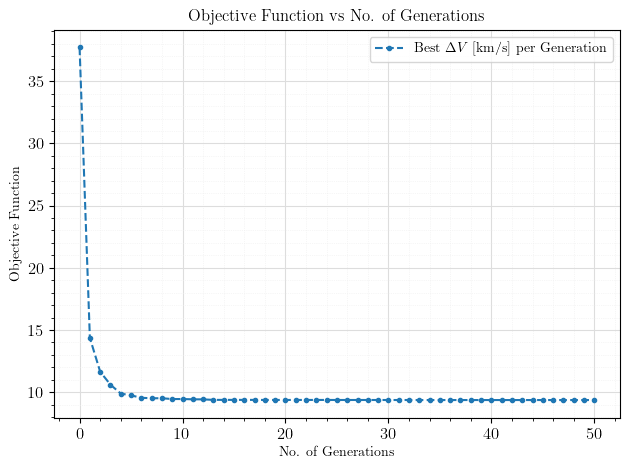

In [138]:
generations = list(range(len(best_solutions_per_generation)))  # X-axis (Generation numbers)
deltaV_values = []  # Y-axis (Best Delta V per generation)
fuel_mass_values = []

for solution in best_solutions_per_generation:
    best_deltaV, best_fuel_mass, _ = find_deltaV_mission(*solution)  # Compute Delta V for each best solution best_fuel_mass,
    deltaV_values.append(best_deltaV)
    #fuel_mass_values.append(best_fuel_mass)

# Plot the data
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

fig, ax = plt.subplots()

plt.plot(generations[:], deltaV_values[:], marker='.', linestyle='--', label="Best $\Delta V$ [km/s] per Generation")
#plt.plot(generations[:], fuel_mass_values[:], marker='.', linestyle='--', label="Best Fuel Mass $(M_f)$ [kg] per Generation")

plt.xlabel("No. of Generations")
plt.ylabel("Objective Function")

plt.title("Objective Function vs No. of Generations")

plt.legend(loc="best")

# Improve grid and ticks
ax.grid(which='major', color='#DDDDDD', linewidth=0.8)
ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
ax.minorticks_on()

# Customize tick parameters
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=10)

plt.tight_layout()

# Show plot
plt.show()

### Fitness Function vs No. of Generations

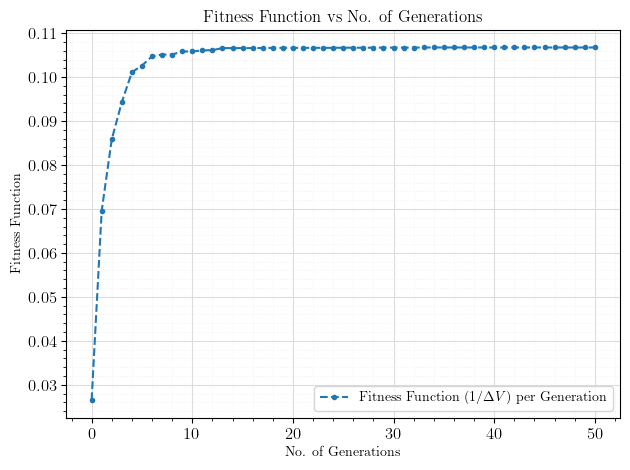

In [140]:
fitness_values_deltaV = 1/np.array(deltaV_values)
#fitness_values_fuel_mass = 1/np.array(fuel_mass_values)

# Plot the data
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

fig, ax = plt.subplots()

plt.plot(generations, fitness_values_deltaV, marker='.', linestyle='--', label="Fitness Function $(1/\Delta V)$ per Generation")
#plt.plot(generations, fitness_values_fuel_mass, marker='.', linestyle='--', label="Fitness Function $(1/M_f)$ per Generation")

plt.xlabel("No. of Generations")
plt.ylabel("Fitness Function")

plt.title("Fitness Function vs No. of Generations")

plt.legend(loc="best")

# Improve grid and ticks
ax.grid(which='major', color='#DDDDDD', linewidth=0.8)
ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
ax.minorticks_on()

# Customize tick parameters
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=10)

plt.tight_layout()

# Show plot
plt.show()

## GA Results --> Fmin

In [360]:
%%time 

# Start timing
start_time = time.time()

# Run optimization using `fmin` with manual bounds enforcement
optimal_dates = fmin(objective_function, GA_list, disp=True, xtol=1e-9, ftol=1e-9, maxiter=1e6, maxfun=1e6)

# Extract optimized dates
date_departure_mjd_GA_FMIN_COMBINED, date_flyby_jupiter_mjd_GA_FMIN_COMBINED, date_flyby_saturn_mjd_GA_FMIN_COMBINED, date_flyby_uranus_mjd_GA_FMIN_COMBINED, date_flyby_neptune_mjd_GA_FMIN_COMBINED = optimal_dates

# Compute Delta-V and fuel mass at optimized dates
deltaV_GA_FMIN_COMBINED, fuel_mass_GA_FMIN_COMBINED, data_dict_GA_FMIN_COMBINED = find_deltaV_mission(*optimal_dates)

# Display results
print(f"\nMinimum Delta-V: {deltaV_GA_FMIN_COMBINED:.4f} km/s")
print(f"Optimal Departure Date (MJD): {date_departure_mjd_GA_FMIN_COMBINED:.2f}")
print(f"Optimal Jupiter Flyby Date (MJD): {date_flyby_jupiter_mjd_GA_FMIN_COMBINED:.2f}")
print(f"Optimal Saturn Flyby Date (MJD): {date_flyby_saturn_mjd_GA_FMIN_COMBINED:.2f}")
print(f"Optimal Uranus Flyby Date (MJD): {date_flyby_uranus_mjd_GA_FMIN_COMBINED:.2f}")
print(f"Optimal Neptune Flyby Date (MJD): {date_flyby_neptune_mjd_GA_FMIN_COMBINED:.2f}")

# Convert MJD dates to calendar dates
print("\nIn calendar dates:")
print(f"Departure: {MJD_to_TT_calander_date(date_departure_mjd_GA_FMIN_COMBINED)}")
print(f"Jupiter flyby: {MJD_to_TT_calander_date(date_flyby_jupiter_mjd_GA_FMIN_COMBINED)}")
print(f"Saturn flyby: {MJD_to_TT_calander_date(date_flyby_saturn_mjd_GA_FMIN_COMBINED)}")
print(f"Uranus flyby: {MJD_to_TT_calander_date(date_flyby_uranus_mjd_GA_FMIN_COMBINED)}")
print(f"Neptune flyby: {MJD_to_TT_calander_date(date_flyby_neptune_mjd_GA_FMIN_COMBINED)}")

# End timing
execution_time_GA_FMIN_COMBINED = time.time() - start_time
print(f"\nExecution Time: {execution_time_GA_FMIN_COMBINED:.4f} seconds")

Optimization terminated successfully.
         Current function value: 9.361167
         Iterations: 548
         Function evaluations: 983

Minimum Delta-V: 9.3612 km/s
Optimal Departure Date (MJD): 43388.85
Optimal Jupiter Flyby Date (MJD): 44116.58
Optimal Saturn Flyby Date (MJD): 44964.49
Optimal Uranus Flyby Date (MJD): 46692.12
Optimal Neptune Flyby Date (MJD): 48107.82

In calendar dates:
Departure: 1977-09-02 20:23:49.350
Jupiter flyby: 1979-08-31 14:00:55.422
Saturn flyby: 1981-12-26 11:45:27.139
Uranus flyby: 1986-09-19 02:53:47.561
Neptune flyby: 1990-08-04 19:35:57.838

Execution Time: 4.3529 seconds
CPU times: user 4.29 s, sys: 31.2 ms, total: 4.32 s
Wall time: 4.35 s


In [362]:
%%time 
# Start timing
start_time = time.time()

# Initialize variables for convergence loop
current_dates = GA_list
previous_dates = None
iteration = 1
max_iterations = 20  # Safety limit
convergence_threshold = 1e-6  # Threshold for considering convergence
converged = False

print("Starting iterative optimization until convergence...")

while not converged and iteration <= max_iterations:
    print(f"\nIteration {iteration}:")
    
    # Run optimization using `fmin` with current dates as starting point
    optimal_dates = fmin(objective_function, current_dates, disp=True, xtol=1e-9, ftol=1e-9, maxiter=1e6, maxfun=1e6)
    
    # Save current dates for comparison
    previous_dates = current_dates.copy()
    current_dates = optimal_dates.copy()
    
    # Check for convergence by comparing arrays
    if previous_dates is not None:
        # Calculate the sum of absolute differences between iterations
        diff = np.sum(np.abs(np.array(current_dates) - np.array(previous_dates)))
        print(f"Sum of absolute differences: {diff:.8f}")
        
        if diff < convergence_threshold:
            converged = True
            print("\nConvergence achieved!")
    
    # Compute and display Delta-V for this iteration
    deltaV, fuel_mass, data_dict = find_deltaV_mission(*current_dates)
    print(f"Current Delta-V: {deltaV:.4f} km/s")
    
    iteration += 1

# Store final optimized results
date_departure_mjd_GA_FMIN_COMBINED = current_dates[0]
date_flyby_jupiter_mjd_GA_FMIN_COMBINED = current_dates[1]
date_flyby_saturn_mjd_GA_FMIN_COMBINED = current_dates[2]
date_flyby_uranus_mjd_GA_FMIN_COMBINED = current_dates[3]
date_flyby_neptune_mjd_GA_FMIN_COMBINED = current_dates[4]

# Compute final Delta-V and fuel mass at optimized dates
deltaV_GA_FMIN_COMBINED, fuel_mass_GA_FMIN_COMBINED, data_dict_GA_FMIN_COMBINED = find_deltaV_mission(*current_dates)

# Display final results
print("\n" + "="*50)
print("FINAL OPTIMISATION RESULTS")
print("="*50)
print(f"\nMinimum Delta-V: {deltaV_GA_FMIN_COMBINED:.4f} km/s")
print(f"Optimal Departure Date (MJD): {date_departure_mjd_GA_FMIN_COMBINED:.6f}")
print(f"Optimal Jupiter Flyby Date (MJD): {date_flyby_jupiter_mjd_GA_FMIN_COMBINED:.6f}")
print(f"Optimal Saturn Flyby Date (MJD): {date_flyby_saturn_mjd_GA_FMIN_COMBINED:.6f}")
print(f"Optimal Uranus Flyby Date (MJD): {date_flyby_uranus_mjd_GA_FMIN_COMBINED:.6f}")
print(f"Optimal Neptune Flyby Date (MJD): {date_flyby_neptune_mjd_GA_FMIN_COMBINED:.6f}")

# Convert MJD dates to calendar dates
print("\nIn calendar dates:")
print(f"Departure: {MJD_to_TT_calander_date(date_departure_mjd_GA_FMIN_COMBINED)}")
print(f"Jupiter flyby: {MJD_to_TT_calander_date(date_flyby_jupiter_mjd_GA_FMIN_COMBINED)}")
print(f"Saturn flyby: {MJD_to_TT_calander_date(date_flyby_saturn_mjd_GA_FMIN_COMBINED)}")
print(f"Uranus flyby: {MJD_to_TT_calander_date(date_flyby_uranus_mjd_GA_FMIN_COMBINED)}")
print(f"Neptune flyby: {MJD_to_TT_calander_date(date_flyby_neptune_mjd_GA_FMIN_COMBINED)}")

# Time statistics
execution_time_GA_FMIN_COMBINED = time.time() - start_time
print(f"\nTotal iterations: {iteration-1}")
print(f"Execution Time: {execution_time_GA_FMIN_COMBINED:.4f} seconds")
print(f"Average time per iteration: {execution_time_GA_FMIN_COMBINED/(iteration-1):.4f} seconds")

Starting iterative optimization until convergence...

Iteration 1:
Optimization terminated successfully.
         Current function value: 9.361167
         Iterations: 548
         Function evaluations: 983
Sum of absolute differences: 1.04756244
Current Delta-V: 9.3612 km/s

Iteration 2:
Optimization terminated successfully.
         Current function value: 9.361164
         Iterations: 468
         Function evaluations: 853
Sum of absolute differences: 0.20022467
Current Delta-V: 9.3612 km/s

Iteration 3:
Optimization terminated successfully.
         Current function value: 9.358177
         Iterations: 1252
         Function evaluations: 2193
Sum of absolute differences: 42.89674884
Current Delta-V: 9.3582 km/s

Iteration 4:
Optimization terminated successfully.
         Current function value: 9.357990
         Iterations: 528
         Function evaluations: 934
Sum of absolute differences: 0.09676111
Current Delta-V: 9.3580 km/s

Iteration 5:
Optimization terminated successfully.


In [297]:
deltaV_GA_FMIN_COMBINED, fuel_mass_GA_FMIN_COMBINED, data_dict_GA_FMIN_COMBINED = find_deltaV_mission(*optimal_dates)
deltaV_GA_FMIN_COMBINED, fuel_mass_GA_FMIN_COMBINED, data_dict_GA_FMIN_COMBINED

(9.35801444035842,
 840.383728286381,
 {'deltaV_injection (km/s)': 9.358014431830666,
  'deltaV_jupiter (km/s)': 5.495259358667681e-09,
  'deltaV_saturn (km/s)': 3.2954972084553447e-10,
  'deltaV_uranus (km/s)': 2.7029454230387273e-09,
  'rp_jupiter (km)': 933073.0905393894,
  'rp_saturn (km)': 212473.9229938127,
  'rp_uranus (km)': 153746.99213171558,
  'tof (days)': 4739.188228620056})

In [299]:
print("Earth-Jupiter:",date_flyby_jupiter_mjd_GA_FMIN_COMBINED - date_departure_mjd_GA_FMIN_COMBINED,"days")
print("Jupiter-Saturn:",date_flyby_saturn_mjd_GA_FMIN_COMBINED - date_flyby_jupiter_mjd_GA_FMIN_COMBINED,"days")
print("Saturn-Uranus:",date_flyby_uranus_mjd_GA_FMIN_COMBINED - date_flyby_saturn_mjd_GA_FMIN_COMBINED,"days")
print("Uranus-Neptune:",date_flyby_neptune_mjd_GA_FMIN_COMBINED - date_flyby_uranus_mjd_GA_FMIN_COMBINED,"days")

Earth-Jupiter: 730.2440835958332 days
Jupiter-Saturn: 851.9222559124319 days
Saturn-Uranus: 1734.7255948067905 days
Uranus-Neptune: 1422.2962943050006 days


In [300]:
change_in_dates_list_FMIN_COMBINED = [
    (date_departure_mjd - date_departure_mjd_GA_FMIN_COMBINED), 
    (date_flyby_jupiter_mjd - date_flyby_jupiter_mjd_GA_FMIN_COMBINED), 
    (date_flyby_saturn_mjd - date_flyby_saturn_mjd_GA_FMIN_COMBINED), 
   (date_flyby_uranus_mjd - date_flyby_uranus_mjd_GA_FMIN_COMBINED), 
   (date_flyby_neptune_mjd - date_flyby_neptune_mjd_GA_FMIN_COMBINED)
]
change_in_dates_list_FMIN_COMBINED

[-10.366641791195434,
 -55.15192909075995,
 -128.86925444765075,
 -38.98732610649313,
 -364.8691643927814]

In [301]:
date_departure_GA_FMIN_COMBINED = MJD_to_TT_calander_date(date_departure_mjd_GA_FMIN_COMBINED)
date_flyby_jupiter_GA_FMIN_COMBINED = MJD_to_TT_calander_date(date_flyby_jupiter_mjd_GA_FMIN_COMBINED)
date_flyby_saturn_GA_FMIN_COMBINED = MJD_to_TT_calander_date(date_flyby_saturn_mjd_GA_FMIN_COMBINED)
date_flyby_uranus_GA_FMIN_COMBINED = MJD_to_TT_calander_date(date_flyby_uranus_mjd_GA_FMIN_COMBINED)
date_flyby_neptune_GA_FMIN_COMBINED = MJD_to_TT_calander_date(date_flyby_neptune_mjd_GA_FMIN_COMBINED)

print("Date of Departure (Min):", MJD_to_TT_calander_date(date_departure_mjd_GA_FMIN_COMBINED))
print("Date of Jupiter Flyby (Min):", MJD_to_TT_calander_date(date_flyby_jupiter_mjd_GA_FMIN_COMBINED))
print("Date of Saturn Flyby (Min):", MJD_to_TT_calander_date(date_flyby_saturn_mjd_GA_FMIN_COMBINED))
print("Date of Uranus Flyby (Min):", MJD_to_TT_calander_date(date_flyby_uranus_mjd_GA_FMIN_COMBINED))
print("Date of Neptune Flyby (Min):", MJD_to_TT_calander_date(date_flyby_neptune_mjd_GA_FMIN_COMBINED))

Date of Departure (Min): 1977-09-02 20:17:08.851
Date of Jupiter Flyby (Min): 1979-09-03 02:08:37.673
Date of Saturn Flyby (Min): 1982-01-02 00:16:40.584
Date of Uranus Flyby (Min): 1986-10-02 17:41:31.976
Date of Neptune Flyby (Min): 1990-08-25 00:48:11.804


# Graph

In [303]:
def plot_VoyagerII(date_departure, date_flyby_jupiter, date_flyby_saturn, 
                   date_flyby_uranus, date_flyby_neptune, colour, label_suffix):
    
    # Convert input dates to Astropy Time in TDB scale
    date_departure = Time(date_departure, scale="tt").tdb
    date_flyby_jupiter = Time(date_flyby_jupiter, scale="tt").tdb
    date_flyby_saturn = Time(date_flyby_saturn, scale="tt").tdb
    date_flyby_uranus = Time(date_flyby_uranus, scale="tt").tdb
    date_flyby_neptune = Time(date_flyby_neptune, scale="tt").tdb

    date_arrival = date_flyby_neptune

    # Define planetary ephemerides
    earth = Ephem.from_body(Earth, time_range(date_departure, end=date_arrival, periods=500))#, plane=Planes.EARTH_ECLIPTIC)
    ss_earth = Orbit.from_ephem(Sun, earth, date_departure)

    jupiter = Ephem.from_body(Jupiter, time_range(date_departure, end=date_arrival, periods=500))#, plane=Planes.EARTH_ECLIPTIC)
    ss_jupiter = Orbit.from_ephem(Sun, jupiter, date_flyby_jupiter)

    saturn = Ephem.from_body(Saturn, time_range(date_departure, end=date_arrival, periods=500))#, plane=Planes.EARTH_ECLIPTIC)
    ss_saturn = Orbit.from_ephem(Sun, saturn, date_flyby_saturn)

    uranus = Ephem.from_body(Uranus, time_range(date_departure, end=date_arrival, periods=500))#, plane=Planes.EARTH_ECLIPTIC)
    ss_uranus = Orbit.from_ephem(Sun, uranus, date_flyby_uranus)

    neptune = Ephem.from_body(Neptune, time_range(date_departure, end=date_arrival, periods=500))#, plane=Planes.EARTH_ECLIPTIC)
    ss_neptune = Orbit.from_ephem(Sun, neptune, date_arrival)

    # Solving for maneuver to Jupiter
    man_flyby_jupiter = Maneuver.lambert(ss_earth, ss_jupiter)
    ic1 = ss_earth.apply_maneuver(man_flyby_jupiter)
    ic1_end = ic1.propagate(date_flyby_jupiter)

    # Solving for maneuver to Saturn
    man_flyby_saturn = Maneuver.lambert(ic1_end, ss_saturn)
    ic2 = ic1_end.apply_maneuver(man_flyby_saturn)
    ic2_end = ic2.propagate(date_flyby_saturn)

    # Solving for maneuver to Uranus
    man_uranus = Maneuver.lambert(ic2_end, ss_uranus)
    ic3 = ic2_end.apply_maneuver(man_uranus)
    ic3_end = ic3.propagate(date_flyby_uranus)

    # Solving for maneuver to Neptune
    man_neptune = Maneuver.lambert(ic3_end, ss_neptune)
    ic4 = ic3_end.apply_maneuver(man_neptune)
    ic4_end = ic4.propagate(date_arrival)

    # Plot Earth's position at departure
    plotter.plot_body_orbit(
        Earth, date_departure, label=f"Earth Departure {label_suffix}", trail=True
    )

    # Plot cruise to Jupiter
    plotter.plot_maneuver(
        ss_earth, man_flyby_jupiter, label=f"Cruise to Jupiter {label_suffix}", color=colour
    )

    # Plot Jupiter's position at flyby
    plotter.plot_body_orbit(
        Jupiter, date_flyby_jupiter, label=f"Jupiter Flyby {label_suffix}", trail=True
    )

    # Plot cruise to Saturn
    plotter.plot_maneuver(
        ic1_end, man_flyby_saturn, label=f"Cruise to Saturn {label_suffix}", color=colour
    )

    # Plot Saturn's position at arrival
    plotter.plot_body_orbit(
        Saturn, date_flyby_saturn, label=f"Saturn Arrival {label_suffix}", trail=True
    )

    # Plot cruise to Uranus
    plotter.plot_maneuver(
        ic2_end, man_uranus, label=f"Cruise to Uranus {label_suffix}", color=colour
    )

    # Plot Uranus's position at arrival
    plotter.plot_body_orbit(
        Uranus, date_flyby_uranus,  label=f"Uranus Arrival {label_suffix}", trail=True
    )

    # Plot cruise to Neptune
    plotter.plot_maneuver(
        ic3_end, man_neptune, label=f"Cruise to Neptune {label_suffix}", color=colour
    )

    # Plot Neptune's position at arrival
    plotter.plot_body_orbit(
        Neptune, date_flyby_neptune,  label=f"Neptune Arrival {label_suffix}", trail=True
    )

### 2-Axis

Figure saved to: Voyager 2 - Figures/voyager_II_trajectory_km_AU.png


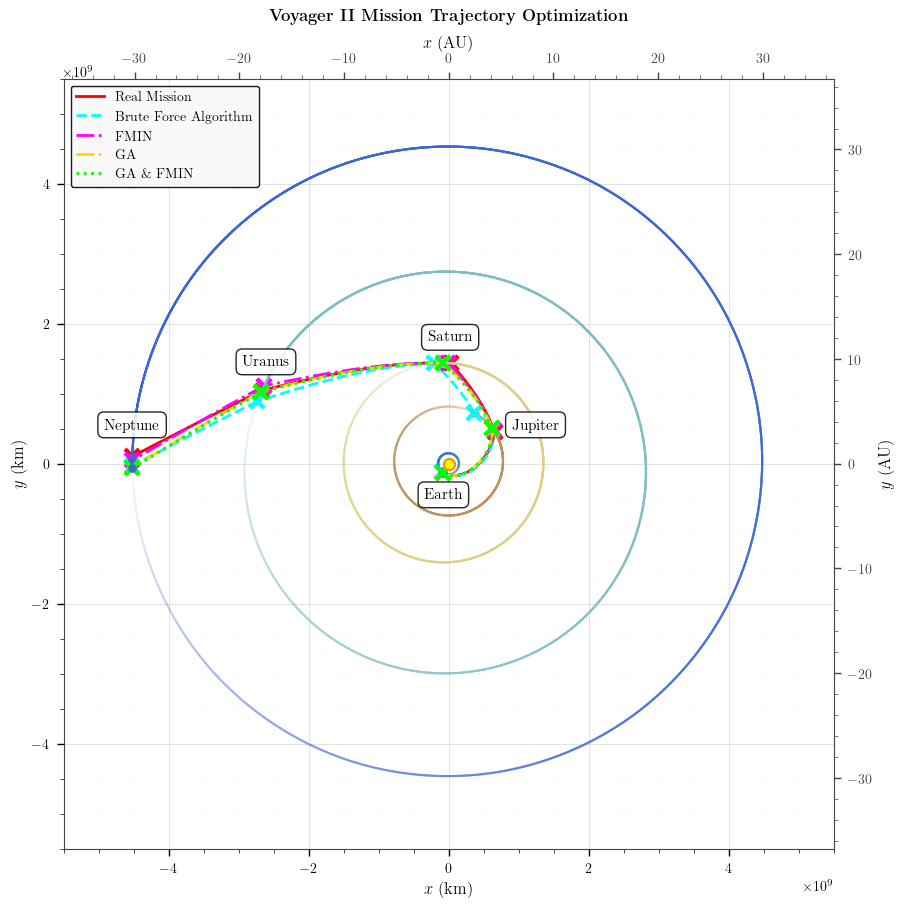

In [317]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Create figure and axis
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111)
plotter = StaticOrbitPlotter(ax)

# Define different line styles for each plot
colours = {
    "Real Mission": "red",
    "Brute Force Algorithm": "cyan",
    "FMIN": "magenta",
    "GA": "gold",
    "GA --> FMIN": "lime"
}

# Plot both missions on the same graph
plot_VoyagerII(date_departure, date_flyby_jupiter, 
               date_flyby_saturn, date_flyby_uranus, 
               date_flyby_neptune, colours["Real Mission"], label_suffix="(Real Mission)")

plot_VoyagerII(date_departure_BRUTE_MIN, date_flyby_jupiter_BRUTE_MIN, 
               date_flyby_saturn_BRUTE_MIN, date_flyby_uranus_BRUTE_MIN, 
               date_flyby_neptune_BRUTE_MIN, colours["Brute Force Algorithm"], label_suffix="(Brute Force Algorithm)")

plot_VoyagerII(date_departure_FMIN, date_flyby_jupiter_FMIN, 
               date_flyby_saturn_FMIN, date_flyby_uranus_FMIN, 
               date_flyby_neptune_FMIN, colours["FMIN"], label_suffix="(FMIN)")

plot_VoyagerII(date_departure_GA, date_flyby_jupiter_GA, 
               date_flyby_saturn_GA, date_flyby_uranus_GA, 
               date_flyby_neptune_GA, colours["GA"], label_suffix="(GA)")

plot_VoyagerII(date_departure_GA_FMIN_COMBINED, date_flyby_jupiter_GA_FMIN_COMBINED, 
               date_flyby_saturn_GA_FMIN_COMBINED, date_flyby_uranus_GA_FMIN_COMBINED, 
               date_flyby_neptune_GA_FMIN_COMBINED, colours["GA --> FMIN"], label_suffix="(GA --> FMIN)")

# Set fixed limits for primary axis
limit = 5.5e9
ax.set_xlim(-limit, limit)
ax.set_ylim(-limit, limit)
ax.set_aspect('equal')  # Square aspect ratio

# Conversion factor (1 AU = 149,597,870.691 km)
km_to_AU = 1 / 149597870.691

# Create second set of axes for AU scale
# These won't be linked to the primary axes in the problematic way
ax_top = fig.add_axes(ax.get_position(), frameon=False)
ax_top.xaxis.tick_top()
ax_top.yaxis.tick_right()
ax_top.set_xlim(ax.get_xlim()[0] * km_to_AU, ax.get_xlim()[1] * km_to_AU)
ax_top.set_ylim(ax.get_ylim()[0] * km_to_AU, ax.get_ylim()[1] * km_to_AU)

# Improve axis labels with LaTeX formatting
ax.set_xlabel(r'$x$ (km)', fontsize=12)
ax.set_ylabel(r'$y$ (km)', fontsize=12)
ax_top.set_xlabel(r'$x$ (AU)', fontsize=12)
ax_top.set_ylabel(r'$y$ (AU)', fontsize=12)
ax_top.xaxis.set_label_position('top')
ax_top.yaxis.set_label_position('right')

# # Add grid
ax.grid(which='major', color='#CCCCCC', linewidth=0.5, linestyle='-', alpha=0.8)
ax.grid(which='minor', color='#DDDDDD', linewidth=0.25, linestyle=':', alpha=0.5)
ax.minorticks_on()
ax_top.grid(False)
ax_top.minorticks_on()

# Customize tick parameters
ax.tick_params(axis='both', which='major', labelsize=10, width=1, length=5, pad=5)
ax.tick_params(axis='both', which='minor', labelsize=8, width=0.5, length=3)
ax_top.tick_params(axis='both', which='major', labelsize=10, width=1, length=5, pad=5, colors='#444444')
ax_top.tick_params(axis='both', which='minor', labelsize=8, width=0.5, length=3, colors='#444444')

# Improved title with LaTeX formatting
plt.title(r"\textbf{Voyager II Mission Trajectory Optimization}", pad=10)

# Function to update AU axes when primary axes change
def update_au_axes(event=None):
    ax_top.set_xlim(ax.get_xlim()[0] * km_to_AU, ax.get_xlim()[1] * km_to_AU)
    ax_top.set_ylim(ax.get_ylim()[0] * km_to_AU, ax.get_ylim()[1] * km_to_AU)
    fig.canvas.draw_idle()

# Connect the update function to the 'xlim_changed' and 'ylim_changed' events
ax.callbacks.connect('xlim_changed', update_au_axes)
ax.callbacks.connect('ylim_changed', update_au_axes)

# Define different line styles for each plot
line_styles = {
    "Real Mission": "-",
    "Brute Force Algorithm": "--",
    "FMIN": "-.",
    "GA": "-.",
    "GA --> FMIN": ":"
}
# Define different line widths for clarity
line_widths = {
    "Real Mission": 2,
    "Brute Force Algorithm": 2,
    "FMIN": 2,
    "GA": 2,
    "GA --> FMIN": 2
}

# Apply line styles
for line in ax.get_lines():
    label = line.get_label()
    for key in line_styles:
        if key in label:
            line.set_linestyle(line_styles[key])
            line.set_linewidth(line_widths[key])

# Create custom legend
handles = [
    Line2D([0], [0], color=colours['Real Mission'], ls=line_styles['Real Mission'], lw=line_widths['Real Mission'], label="Real Mission"),
    Line2D([0], [0], color=colours['Brute Force Algorithm'], ls=line_styles['Brute Force Algorithm'], lw=line_widths['Brute Force Algorithm'], label="Brute Force Algorithm"),
    Line2D([0], [0], color=colours['FMIN'], ls=line_styles['FMIN'], lw=line_widths['FMIN'], label="FMIN"),
    Line2D([0], [0], color=colours['GA'], ls=line_styles['GA'], lw=line_widths['GA'], label="GA"),
    Line2D([0], [0], color=colours['GA --> FMIN'], ls=line_styles['GA --> FMIN'], lw=line_widths['GA --> FMIN'], label="GA \& FMIN")
]

# Sun
ax.plot(0, 0, 'o', markersize=8, markerfacecolor='#FFFF00', markeredgecolor='#FF8C00', markeredgewidth=1.5, zorder=100)

# Add legend with improved styling
legend = ax.legend(handles=handles, loc="upper left", ncol=1, frameon=True, 
          edgecolor='black', fontsize=10, #title=r"\textbf{Optimisation Methods}", 
          title_fontsize=11)
legend.get_frame().set_alpha(0.9)
legend.get_frame().set_facecolor('#F9F9F9')

# Planet colors
planet_colors = {
    "Earth": "#3366FF",    # Blue
    "Jupiter": "#FF9933",  # Orange
    "Saturn": "#FFCC33"    # Yellow
}

# Use the new label positions provided
planet_label_positions = {
    "Earth": (-0.35e9, -0.5e9),
    "Jupiter": (0.9e9, 0.5e9),
    "Saturn": (-0.3e9, 1.75e9),
    "Uranus": (-2.95e9, 1.4e9),
    "Neptune": (-4.925e9, 0.5e9)
}

# Add each planet marker and label
for planet, position in planet_label_positions.items():
    x, y = position
    
    # Use the absolute positions for labels instead of offsets
    label_x, label_y = planet_label_positions[planet]
    
    # Improved annotation style
    bbox_props = dict(boxstyle="round,pad=0.4", fc="white", ec="black", alpha=0.85)
    ax.annotate(planet, 
               xy=(x, y),  # Position of the planet
               xytext=(label_x, label_y),  # Absolute position for the label
               textcoords='data',  # Changed from 'offset points' to 'data'
               bbox=bbox_props,
               fontsize=11,
               fontweight='bold',
               zorder=101,  # Ensure labels appear on top of everything
               )  # Add arrow connecting label to planet

# Add a thin border around the plot for a more professional look
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(0.8)
    spine.set_color('#444444')

output_figures.save_file("voyager_II_trajectory_km_AU.png", dpi=500, bbox_inches="tight")

# Show plot
plt.show()

### 2-Axis Zoomed

Figure saved to: Voyager 2 - Figures/voyager_II_trajectory_zoom.png


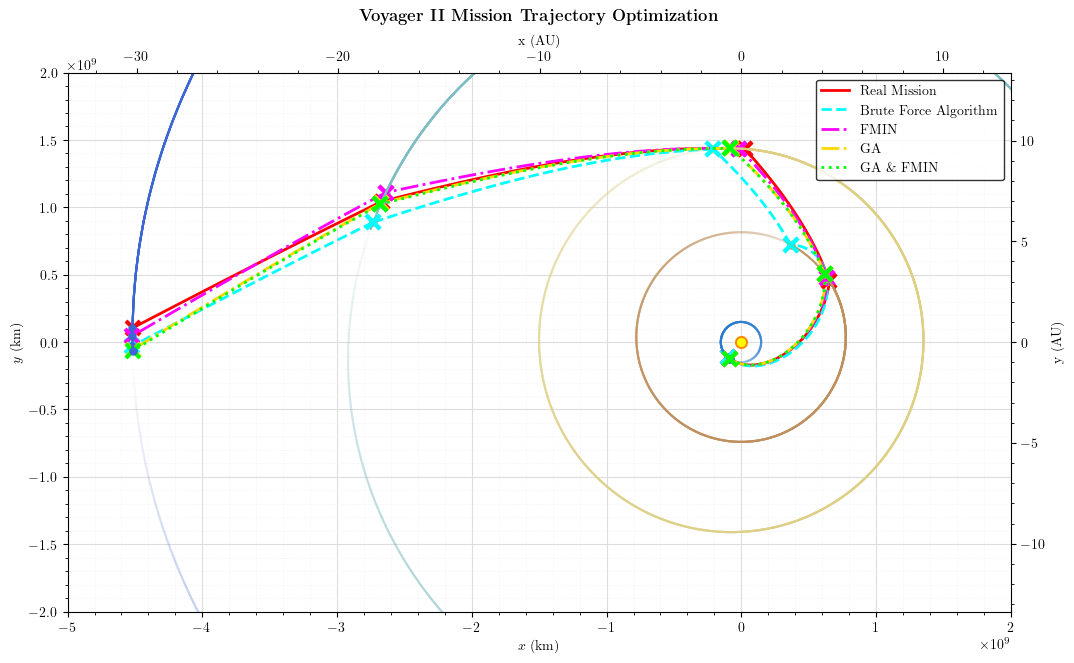

In [320]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

fig, ax = plt.subplots(figsize=(9, 7))
plotter = StaticOrbitPlotter(ax)

# Plot both missions on the same graph
plot_VoyagerII(date_departure, date_flyby_jupiter, 
               date_flyby_saturn, date_flyby_uranus, 
               date_flyby_neptune, colours["Real Mission"], label_suffix="(Real Mission)")

plot_VoyagerII(date_departure_BRUTE_MIN, date_flyby_jupiter_BRUTE_MIN, 
               date_flyby_saturn_BRUTE_MIN, date_flyby_uranus_BRUTE_MIN, 
               date_flyby_neptune_BRUTE_MIN, colours["Brute Force Algorithm"], label_suffix="(Brute Force Algorithm)")

plot_VoyagerII(date_departure_FMIN, date_flyby_jupiter_FMIN, 
               date_flyby_saturn_FMIN, date_flyby_uranus_FMIN, 
               date_flyby_neptune_FMIN, colours["FMIN"], label_suffix="(FMIN)")

plot_VoyagerII(date_departure_GA, date_flyby_jupiter_GA, 
               date_flyby_saturn_GA, date_flyby_uranus_GA, 
               date_flyby_neptune_GA, colours["GA"], label_suffix="(GA)")

plot_VoyagerII(date_departure_GA_FMIN_COMBINED, date_flyby_jupiter_GA_FMIN_COMBINED, 
               date_flyby_saturn_GA_FMIN_COMBINED, date_flyby_uranus_GA_FMIN_COMBINED, 
               date_flyby_neptune_GA_FMIN_COMBINED, colours["GA --> FMIN"], label_suffix="(GA --> FMIN)")

# Set fixed limits for primary axis
plt.xlim(-5e9, 2e9)
plt.ylim(-2e9, 2e9)
ax.set_aspect('equal')  # Square aspect ratio

# Conversion factor (1 AU = 149,597,870.691 km)
km_to_AU = 1 / 149597870.691

# Create second set of axes for AU scale
# These won't be linked to the primary axes in the problematic way
ax_top = fig.add_axes(ax.get_position(), frameon=False)
ax_top.xaxis.tick_top()
ax_top.yaxis.tick_right()
ax_top.set_xlim(ax.get_xlim()[0] * km_to_AU, ax.get_xlim()[1] * km_to_AU)
ax_top.set_ylim(ax.get_ylim()[0] * km_to_AU, ax.get_ylim()[1] * km_to_AU)
ax_top.set_xlabel("x (AU)")#, labelpad=10)
ax_top.set_ylabel("y (AU)")#, labelpad=10)
ax_top.xaxis.set_label_position('top')
ax_top.yaxis.set_label_position('right')

# Add grid
ax.grid(which='major', color='#DDDDDD', linewidth=0.8)
ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
ax.minorticks_on()
#ax_top.grid(which='major', color='#DDDDDD', linewidth=0.8)
#ax_top.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
ax_top.minorticks_on()

# Customize tick parameters
ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='both', which='minor', labelsize=8)
ax_top.tick_params(axis='both', which='major', labelsize=10)
ax_top.tick_params(axis='both', which='minor', labelsize=8)

plt.title(r"\textbf{Voyager II Mission Trajectory Optimization}", pad=10)

# Function to update AU axes when primary axes change
def update_au_axes(event=None):
    ax_top.set_xlim(ax.get_xlim()[0] * km_to_AU, ax.get_xlim()[1] * km_to_AU)
    ax_top.set_ylim(ax.get_ylim()[0] * km_to_AU, ax.get_ylim()[1] * km_to_AU)
    fig.canvas.draw_idle()

# Connect the update function to the 'xlim_changed' and 'ylim_changed' events
ax.callbacks.connect('xlim_changed', update_au_axes)
ax.callbacks.connect('ylim_changed', update_au_axes)

# Apply line styles
for line in ax.get_lines():
    label = line.get_label()
    for key in line_styles:
        if key in label:
            line.set_linestyle(line_styles[key])
            line.set_linewidth(line_widths[key])

# Create custom legend
handles = [
    Line2D([0], [0], color=colours['Real Mission'], ls=line_styles['Real Mission'], lw=line_widths['Real Mission'], label="Real Mission"),
    Line2D([0], [0], color=colours['Brute Force Algorithm'], ls=line_styles['Brute Force Algorithm'], lw=line_widths['Brute Force Algorithm'], label="Brute Force Algorithm"),
    Line2D([0], [0], color=colours['FMIN'], ls=line_styles['FMIN'], lw=line_widths['FMIN'], label="FMIN"),
    Line2D([0], [0], color=colours['GA'], ls=line_styles['GA'], lw=line_widths['GA'], label="GA"),
    Line2D([0], [0], color=colours['GA --> FMIN'], ls=line_styles['GA --> FMIN'], lw=line_widths['GA --> FMIN'], label="GA \& FMIN")
]

# Sun
ax.plot(0, 0, 'o', markersize=8, markerfacecolor='#FFFF00', markeredgecolor='#FF8C00', markeredgewidth=1.5, zorder=100)

# Add legend
ax.legend(handles=handles, loc="best", ncol=1, frameon=True, edgecolor='black')

output_figures.save_file("voyager_II_trajectory_zoom.png", dpi=500, bbox_inches="tight")

# Show plot
plt.show()

In [322]:
deltaV_REAL, fuel_mass_REAL, data_dict_REAL

(14.36247781408503,
 1139.0,
 {'deltaV_injection (km/s)': 9.777779726682427,
  'deltaV_jupiter (km/s)': 0.022610023336749663,
  'deltaV_saturn (km/s)': 0.8231855964923582,
  'deltaV_uranus (km/s)': 3.738902467573496,
  'rp_jupiter (km)': 712698.8242066916,
  'rp_saturn (km)': 217314.15315946675,
  'rp_uranus (km)': 77945.15343930262,
  'tof (days)': 4384.68570601847})

In [323]:
deltaV_BRUTE_MIN, fuel_mass_BRUTE_MIN, data_dict_BRUTE_MIN

(10.192898693827132,
 896.1706929705995,
 {'deltaV_injection (km/s)': 9.477237719217307,
  'deltaV_jupiter (km/s)': 0.5826092617392575,
  'deltaV_saturn (km/s)': 0.09611727527946101,
  'deltaV_uranus (km/s)': 0.03693443759110693,
  'rp_jupiter (km)': 96694.86737610104,
  'rp_saturn (km)': 166934.94660901834,
  'rp_uranus (km)': 139025.60162481232,
  'tof (days)': 5033.574594907361})

In [324]:
deltaV_FMIN, fuel_mass_FMIN, data_dict_FMIN

(9.412354252811033,
 844.0943192792565,
 {'deltaV_injection (km/s)': 9.412354231781963,
  'deltaV_jupiter (km/s)': 2.1027979357768345e-08,
  'deltaV_saturn (km/s)': 4.547473508864641e-13,
  'deltaV_uranus (km/s)': 6.359357485052897e-13,
  'rp_jupiter (km)': 799386.3999994716,
  'rp_saturn (km)': 175111.02199466518,
  'rp_uranus (km)': 120973.6693789514,
  'tof (days)': 4498.443799353488})

In [325]:
deltaV_GA, fuel_mass_GA, dict_GA = find_deltaV_mission(*GA_list)
deltaV_GA, fuel_mass_GA, dict_GA

(9.369043404617052,
 841.1377507832318,
 {'deltaV_injection (km/s)': 9.361080764998041,
  'deltaV_jupiter (km/s)': 0.0003318674548360434,
  'deltaV_saturn (km/s)': 0.00036609910977958293,
  'deltaV_uranus (km/s)': 0.007264673054395487,
  'rp_jupiter (km)': 922119.2855491277,
  'rp_saturn (km)': 209107.02952773124,
  'rp_uranus (km)': 150486.55636449813,
  'tof (days)': 4718.199138499811})

In [326]:
deltaV_GA_FMIN_COMBINED, fuel_mass_GA_FMIN_COMBINED, data_dict_GA_FMIN_COMBINED

(9.35801444035842,
 840.383728286381,
 {'deltaV_injection (km/s)': 9.358014431830666,
  'deltaV_jupiter (km/s)': 5.495259358667681e-09,
  'deltaV_saturn (km/s)': 3.2954972084553447e-10,
  'deltaV_uranus (km/s)': 2.7029454230387273e-09,
  'rp_jupiter (km)': 933073.0905393894,
  'rp_saturn (km)': 212473.9229938127,
  'rp_uranus (km)': 153746.99213171558,
  'tof (days)': 4739.188228620056})

In [327]:
deltaVs = {
    "REAL": deltaV_REAL,
    "Brute Force": deltaV_BRUTE_MIN,
    "Fmin": deltaV_FMIN,
    "Genetic Algorithm": deltaV_GA,
    "Combined (Genetic Algorithm + Fmin)": deltaV_GA_FMIN_COMBINED
}

for method in deltaVs:
    print(f"{method}: {deltaVs[method]:.4f} km/s")

REAL: 14.3625 km/s
Brute Force: 10.1929 km/s
Fmin: 9.4124 km/s
Genetic Algorithm: 9.3690 km/s
Combined (Genetic Algorithm + Fmin): 9.3580 km/s


In [328]:
fuel_mass_values = {
    "REAL": fuel_mass_REAL,
    "Brute Force": fuel_mass_BRUTE_MIN,
    "Fmin": fuel_mass_FMIN,
    "Genetic Algorithm": fuel_mass_GA,
    "Combined (Genetic Algorithm + Fmin)": fuel_mass_GA_FMIN_COMBINED
}

for method in fuel_mass_values:
    print(f"{method}: {fuel_mass_values[method]:.2f} kg")

REAL: 1139.00 kg
Brute Force: 896.17 kg
Fmin: 844.09 kg
Genetic Algorithm: 841.14 kg
Combined (Genetic Algorithm + Fmin): 840.38 kg


In [329]:
execution_time_dict = {
    "Brute Force": execution_time_BRUTE_FORCE,
    "Fmin": execution_time_FMIN,
    "Genetic Algorithm": execution_time_GA,
    "Combined (Genetic Algorithm + Fmin)": execution_time_GA_FMIN_COMBINED
}

for method, time in execution_time_dict.items():
    print(f"{method}: {time:.2f} seconds")

Brute Force: 630.37 seconds
Fmin: 7.94 seconds
Genetic Algorithm: 1484.33 seconds
Combined (Genetic Algorithm + Fmin): 15.92 seconds


### Comparsion Table

In [331]:
# Data
methods = ["REAL", "Brute Force", "Genetic Algorithm", "Fmin", "Combined (Genetic Algorithm + Fmin)"]

data = {
    "Method": methods,
    "deltaV (km/s)": [deltaVs[method] for method in methods],
    "Fuel Mass (kg)": [fuel_mass_values[method] for method in methods],
    "Execution Time (s)": [execution_time_dict.get(method, None) for method in methods],
    "Departure Change (days)": [0, change_in_dates_list_BRUTE_MIN[0], change_in_dates_list_FMIN[0], change_in_dates_list_GA[0], change_in_dates_list_FMIN_COMBINED[0]],
    "Jupiter Flyby Change (days)": [0, change_in_dates_list_BRUTE_MIN[1], change_in_dates_list_FMIN[1], change_in_dates_list_GA[1], change_in_dates_list_FMIN_COMBINED[1]],
    "Saturn Flyby Change (days)": [0, change_in_dates_list_BRUTE_MIN[2], change_in_dates_list_FMIN[2], change_in_dates_list_GA[2], change_in_dates_list_FMIN_COMBINED[2]],
    "Uranus Flyby Change (days)": [0, change_in_dates_list_BRUTE_MIN[3], change_in_dates_list_FMIN[3], change_in_dates_list_GA[3], change_in_dates_list_FMIN_COMBINED[3]],
    "Neptune Flyby Change (days)": [0, change_in_dates_list_BRUTE_MIN[4], change_in_dates_list_FMIN[4], change_in_dates_list_GA[4], change_in_dates_list_FMIN_COMBINED[4]]
}

df = pd.DataFrame(data)
df

,Method,deltaV (km/s),Fuel Mass (kg),Execution Time (s),Departure Change (days),Jupiter Flyby Change (days),Saturn Flyby Change (days),Uranus Flyby Change (days),Neptune Flyby Change (days)
0,REAL,14.362478,1139.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000
1,Brute Force,10.192899,896.170693,630.374351,365.000000,-365.000000,-283.888889,-283.888889,-283.888889
2,Genetic Algorithm,9.369043,841.137751,1484.334947,-9.851522,-23.699697,-49.692335,124.961588,-123.609615
3,Fmin,9.412354,844.094319,7.939037,-10.406205,-52.726733,-122.459792,25.458401,343.919638
4,Combined (Genetic Algorithm + Fmin),9.358014,840.383728,15.923343,-10.366642,-55.151929,-128.869254,-38.987326,-364.869164


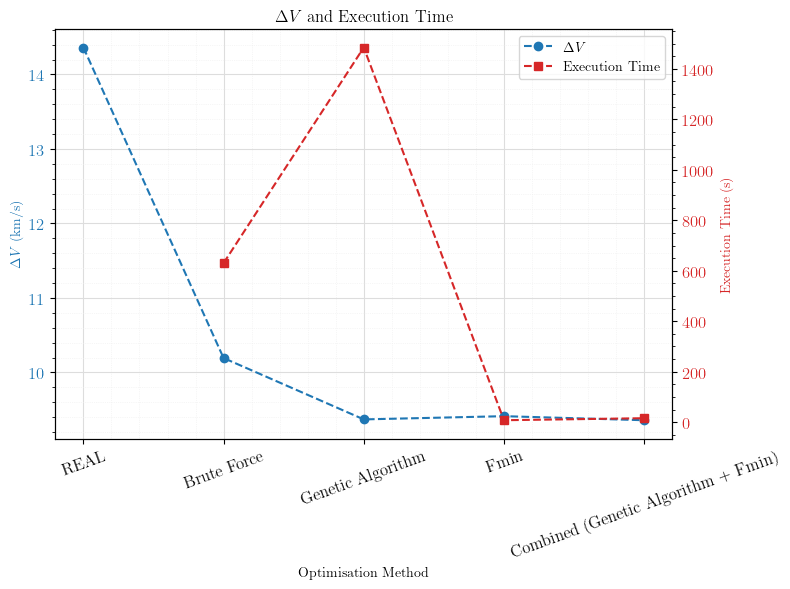

In [341]:
# Apply LaTeX styling
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

deltaV_values_method = [deltaVs[name] for name in methods]
execution_methods = [m for m in methods if m in execution_time_dict]
execution_times = [execution_time_dict[name] for name in execution_methods]

# Convert to numpy arrays for plotting
deltaV_values_method = np.array(deltaV_values_method, dtype=float)
execution_times = np.array(execution_times, dtype=float)

fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot delta-V
ax1.set_xlabel("Optimisation Method")
ax1.set_ylabel("$\Delta V$ (km/s)", color='tab:blue')
ax1.plot(methods, deltaV_values_method, marker='o', linestyle='--', color='tab:blue', label="$\Delta V$")
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_xticks(range(len(methods)))
ax1.set_xticklabels(methods, ha='center', rotation=20, fontsize=12)

# Secondary axis for execution time
ax2 = ax1.twinx()
ax2.set_ylabel("Execution Time (s)", color='tab:red')
ax2.plot(execution_methods, execution_times, marker='s', linestyle='--', color='tab:red', label="Execution Time")
ax2.tick_params(axis='y', labelcolor='tab:red')

# Add legends
ax1.legend(loc='upper right', handles=ax1.lines + ax2.lines, labels=["$\Delta V$", "Execution Time"])

# Improve grid and ticks
ax1.grid(which='major', color='#DDDDDD', linewidth=0.8)
ax1.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)

ax1.minorticks_on()
ax2.minorticks_on()
ax1.tick_params(axis='both', which='major', labelsize=12)
ax2.tick_params(axis='both', which='major', labelsize=12)

ax1.tick_params(axis='x', which='minor', length=0)

#ax1.set_ylim(9.3,10.4)
#ax2.set_ylim(0,500)

# Show title
plt.title("$\Delta V$ and Execution Time")
plt.tight_layout()
plt.show()

In [164]:
#math.factorial(20)

In [165]:
#scipy.optimise --> fmin

#Add Rocket Equation to convert back to fuel mass